# Modeling for Football Data from Transfermarkt
- Kaggle Data URL

    - https://www.kaggle.com/datasets/davidcariboo/player-scores

## 1. 데이터 설명

- `csv` 파일 설명
    - `apperances` : 선수 출장 기록
    - `club_games` : 클럽별 경기 홈팀, 어웨이팀 정보
    - `clubs` : 리그별 속해 있는 클럽
    - `competitions` : 대회 정보
    - `game_events` : 경기별 이벤트 정보 (카드, 득점, 어시스트 등)
    - `game_lineups` : 경기별 선수의 선발, 교체 명단 등재 여부
    - `games` : 경기에 대한 정보 (시즌, 라운드, 홈팀, 어웨이팀, 순위)
    - `player_valuations` : Transfermarkt 웹사이트에서 매긴 선수의 가치
    - `players` : 선수에 대한 세부 정보

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from lightgbm import Dataset as lgb_Dataset
from lightgbm import early_stopping
from catboost import CatBoostRegressor
from catboost import Pool

from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import TargetEncoder

from xgboost import plot_importance

import pickle
import os

import shap

import warnings
warnings.filterwarnings(action='ignore')
pd.set_option("display.max_columns", None)

plt.rc('font', family='Noto Sans')
plt.rcParams['axes.unicode_minus'] = False

c:\Users\aryij\anaconda3\envs\football\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [186]:
# 데이터 경로
path = "data/df_final.csv"
df_original = pd.read_csv(path)

### 1-1. 컬럼 변환

In [187]:
# 출장시간 로그 변환
df_original["log_minutes_played"] = np.log1p(df_original["minutes_played"])

# start_season 수치형 → 카테고리형 데이터로 변환
df_original["start_season"] = pd.Categorical(df_original["start_season"], ordered=False)

# position_category 카테고리형 데이터로 변환
df_original["position_category"] = pd.Categorical(df_original["position_category"], ordered=False)

In [188]:
df_original.head()

,player_name,start_season,yellow_cards,red_cards,goals,assists,minutes_played,competition_code,date_of_birth,position,team_title,market_value_per_season,country,foot,height_in_cm,xA,shots,key_passes,npG,npxG,xGChain,xGBuildup,age,aggression,goals_90,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_per_shot,npxG_per_shot,goal_conv,npG_conv,npG_vs_npxG,position_category,log_market_value_per_season,log_minutes_played
0,Aarón Martín,2019,2.0,0.0,0.0,0.0,1795.0,bundesliga,1997-04-22,Left-Back,Mainz 05,10500000.0,Spain,left,178.0,3.250888,9.0,32.0,0.0,0.294448,3.658402,2.195273,23,0.6,0.000000,0.000000,0.030084,0.000000,0.014763,0.162997,0.451253,1.604457,0.183430,0.110069,0.000000,0.032716,0.000000,0.000000,-0.294448,Defender,16.166886,7.493317
1,Abdelhamid Sabiri,2019,6.0,0.0,4.0,1.0,1035.0,bundesliga,1996-11-28,Attacking Midfield,Paderborn,1700000.0,Morocco,right,186.0,0.232751,43.0,7.0,3.0,2.711101,1.644770,0.885899,23,1.8,0.347826,0.086957,0.156522,0.260870,0.235748,0.020239,3.739130,0.608696,0.143023,0.077035,0.069767,0.063049,0.093023,0.069767,0.288899,Midfielder,14.346139,6.943122
2,Achraf Hakimi,2019,5.0,0.0,5.0,10.0,2717.0,bundesliga,1998-11-04,Right-Back,Borussia Dortmund,54000000.0,Morocco,right,181.0,5.510969,38.0,36.0,5.0,5.067438,24.144373,16.293885,21,1.5,0.165624,0.331248,0.049687,0.165624,0.167858,0.182550,1.258741,1.192492,0.799777,0.539731,0.131579,0.133354,0.131579,0.131579,-0.067438,Defender,17.804495,7.907652
3,Adam Bodzek,2019,10.0,0.0,0.0,0.0,2018.0,bundesliga,1985-09-07,Defensive Midfield,Fortuna Duesseldorf,325000.0,Poland,right,184.0,0.270701,9.0,8.0,0.0,0.697913,2.535295,1.791962,34,3.0,0.000000,0.000000,0.133796,0.000000,0.031126,0.012073,0.401388,0.356789,0.113071,0.079919,0.000000,0.077546,0.000000,0.000000,-0.697913,Midfielder,12.691584,7.610358
4,Admir Mehmedi,2019,0.0,0.0,2.0,2.0,1205.0,bundesliga,1991-03-16,Second Striker,Wolfsburg,8000000.0,Switzerland,right,183.0,2.166826,22.0,19.0,2.0,1.536662,6.112824,3.069346,29,0.0,0.149378,0.149378,0.000000,0.149378,0.114771,0.161838,1.643154,1.419087,0.456559,0.229246,0.090909,0.069848,0.090909,0.090909,0.463338,Forward,15.894952,7.095064


In [5]:
cols_to_use = ['start_season', 'log_minutes_played', 'competition_code', 'position', 
               'country', 'foot', 'height_in_cm', 'age',  
               'assists_90', 'aggression_90', 'npG_90', 'npxG_90', 'xA_90', 
               'shots_90', 'key_passes_90', 'xGChain_90', 'xGBuildup_90', 'npG_conv', 
               'position_category', 'log_market_value_per_season']

In [6]:
len(cols_to_use)

20

In [189]:
df = df_original[cols_to_use]

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6950 entries, 0 to 6949
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   start_season                 6950 non-null   category
 1   log_minutes_played           6950 non-null   float64 
 2   competition_code             6950 non-null   object  
 3   position                     6950 non-null   object  
 4   country                      6950 non-null   object  
 5   foot                         6950 non-null   object  
 6   height_in_cm                 6950 non-null   float64 
 7   age                          6950 non-null   int64   
 8   assists_90                   6950 non-null   float64 
 9   aggression_90                6950 non-null   float64 
 10  npG_90                       6950 non-null   float64 
 11  npxG_90                      6950 non-null   float64 
 12  xA_90                        6950 non-null   float64 
 13  sho

In [9]:
# 수치형, 범주형 변수 따로 선언
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

In [10]:
print("수치형 변수 :", num_cols)
print("범주형 변수 :", cat_cols)

수치형 변수 : ['log_minutes_played', 'height_in_cm', 'age', 'assists_90', 'aggression_90', 'npG_90', 'npxG_90', 'xA_90', 'shots_90', 'key_passes_90', 'xGChain_90', 'xGBuildup_90', 'npG_conv', 'log_market_value_per_season']
범주형 변수 : ['start_season', 'competition_code', 'position', 'country', 'foot', 'position_category']


In [11]:
# 범주형 변수 카테고리 데이터로 변경
for col in cat_cols:
    df[col] = pd.Categorical(df[col])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6950 entries, 0 to 6949
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   start_season                 6950 non-null   category
 1   log_minutes_played           6950 non-null   float64 
 2   competition_code             6950 non-null   category
 3   position                     6950 non-null   category
 4   country                      6950 non-null   category
 5   foot                         6950 non-null   category
 6   height_in_cm                 6950 non-null   float64 
 7   age                          6950 non-null   int64   
 8   assists_90                   6950 non-null   float64 
 9   aggression_90                6950 non-null   float64 
 10  npG_90                       6950 non-null   float64 
 11  npxG_90                      6950 non-null   float64 
 12  xA_90                        6950 non-null   float64 
 13  sho

In [13]:
# 다중 공선성 확인
def feature_engineering_XbyVIF(df):
    # NaN 값이 있는 경우 처리
    if df.isnull().values.any():
        raise ValueError("데이터프레임에 NaN 값이 포함되어 있습니다. NaN 값을 처리해 주세요.")
    
    # 스케일링 (RobustScaler 사용)
    scaler = RobustScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]
    vif['Feature'] = df.columns
    
    return vif

In [14]:
feature_engineering_XbyVIF(df[num_cols])
# npxG_90, xGChain_90 높다 (10 이상)

,VIF_Factor,Feature
0,1.304452,log_minutes_played
1,1.392187,height_in_cm
2,1.511998,age
3,3.172469,assists_90
4,1.116207,aggression_90
5,8.315667,npG_90
6,13.679624,npxG_90
7,8.449089,xA_90
8,7.036094,shots_90
9,5.963279,key_passes_90


## 2. 데이터 분리

In [15]:
# target 컬럼 "log_market_value_per_season"
target = "log_market_value_per_season"
# 나머지 컬럼 features에 선언
features = df.drop(columns=target).columns

# 학습할 train 데이터 : 19-20 ~ 22-23 시즌 데이터 (4시즌)
train = df[df.start_season != 2023]
# 예측할 test 데이터 : 23-24 시즌 데이터
test = df[df.start_season == 2023]

train.shape, test.shape

((5509, 20), (1441, 20))

In [16]:
# validation 데이터셋 생성
train, val = train_test_split(train, 
                            # test와 train의 비율로 validation 데이터 크기 맞춘다
                              test_size=test.shape[0]/train.shape[0],
                              random_state=42)

In [17]:
# train 데이터 나눠준다
X_train = train[features]
y_train = train[target]

# validation 데이터 나눠준다
X_val = val[features]
y_val = val[target]

# test 데이터 나눠준다
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4067, 19), (4067,), (1442, 19), (1442,), (1441, 19), (1441,))

In [18]:
# train 데이터 copy
X_train_no_enc = train[features].copy()

# validation 데이터 copy
X_val_no_enc = val[features].copy()

# test 데이터 copy
X_test_no_enc = test[features].copy()

## 3. 모델링

### 3-1. 인코딩 (Target Encoding)

**Target Encoding**
- 머신 러닝 모델의 출력이 숫자 (회귀)일 때만 범주형 feature에 사용

- 각 범주에 대한 평균 목표값 계산 → 인코딩 하기 위해 범주형 값이 갖는 범주에 해당하는 백분율 대체
- 각 카테고리의 값을 학습 데이터의 target 값의 평균값으로 설정한다
- 데이터 관측치가 많아야 한다
- 과적합의 원인이 될 수 있다
- references
    - https://conanmoon.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99-%EC%9C%A0%EB%A7%9D%EC%A3%BC%EC%9D%98-%EB%A7%A4%EC%9D%BC-%EA%B8%80%EC%93%B0%EA%B8%B0-%EC%9D%BC%EA%B3%B1%EB%B2%88%EC%A7%B8-%EC%9D%BC%EC%9A%94%EC%9D%BC-7a40e7de39d4
    - https://velog.io/@seungwoong12/encoding

In [19]:
# Scikit-learn TargetEncoder 사용
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html
# Scikit-learn 버전 높아야 사용 가능 (업데이트 필요)

# 범주형 변수 목록 cat_features에 선언
cat_features = df.select_dtypes(exclude=np.number).columns.tolist()

# smooth="auto", cv=5로 TargetEncoder 객체 생성
te = TargetEncoder(target_type="continuous", smooth="auto", cv=5)

for cat_feature in cat_features:
    # Train 데이터로 fit_transform 해준다
    X_train[cat_feature] = te.fit_transform(X_train[[cat_feature]], y_train)
    X_val[cat_feature] = te.transform(X_val[[cat_feature]])
    X_test[cat_feature] = te.transform(X_test[[cat_feature]])

### 3-2. 회귀모델 평가 지표  
- `RMSLE`
    - MSE에 루트를 씌운 RMSE의 각 인자에 로그를 취해준 값
        - 로그 변환을 통해 이상치에 대한 영향을 줄이고, 모델이 이상치에 대해 과도하게 페널티를 받지 않게 한다
        - 과소평가된 항목에 큰 패널티를 부여한다
        - 상대적 ERROR 측정
        - 값의 범위가 넓은 데이터에서 이상치에 대해 변화의 폭이 크지 않다
    - 정규 분포를 따르지 않고 불균형한 모형일 때 사용되는 방법

- `R2 Score` (결정 계수)
    - 종속 변수의 총 변동 중 모델이 설명하는 변동의 비율
    - 0 ~ 1 사이의 값을 가지며, 높을 수록 모델이 데이터를 잘 설명한다는 뜻

- 평가 지표 선정 이유
    - 예측하고자 하는 타겟에 이상치가 많이 존재한다 (`market_value_per_season`)
        - `RMSLE` : 이상치에 강건한 특성을 갖는다
            - 실제보다 작게 예측이 되었을 때 페널티를 더 크게 부여한다
            - 선수 몸값이 실제 몸값 보다 적게 측정된다면, 
                - Transfermarkt 웹사이트가 몸값을 부풀린다고 오해받을 수 있다 
                - 실제 이적시장에 거품이 많이 끼어있다고 생각할 수도 있다
            - 따라서 과소 평가 항목에 페널티를 주는 `RMSLE`를 통해 평가
        - `R2 Score` : 모델이 얼마나 데이터의 변동을 잘 설명하는지 평가

- References
    - https://shinminyong.tistory.com/32
    - https://wikidocs.net/219419
    - https://www.inflearn.com/questions/992421/rmsle%EC%9D%98-%EC%82%AC%EC%9A%A9%EC%97%90-%EA%B4%80%ED%95%9C-%EC%A7%88%EB%AC%B8%EC%9E%85%EB%8B%88%EB%8B%A4

In [20]:
def calculate_rmsle(y_actual, y_pred):
    """
    Root Mean Squared Logarithmic Error (RMSLE)를 계산하는 함수.
    
    Parameters:
    - y_actual: 실제 값 (array-like)
    - y_pred: 예측 값 (array-like)
    
    Returns:
    - RMSLE 값 (float)
    """
    # 음수 값 방지
    y_actual = np.maximum(0, y_actual)
    y_pred = np.maximum(0, y_pred)
    
    # 로그 변환 후 차이 계산
    log_y_actual = np.log1p(y_actual)
    log_y_pred = np.log1p(y_pred)
    squared_error = (log_y_actual - log_y_pred) ** 2
    
    # 평균 제곱근 로그 오차 계산
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

### 3-3. Baseline 모델 생성

In [21]:
# https://medium.com/machine-learning-with-python/multiple-linear-regression-implementation-in-python-2de9b303fc0c

In [22]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [23]:
def baseline_model(model_name, model):
    # 결과 저장 리스트 초기화
    baseline_results = []

    print(f"\n====== Baseline Model : {model_name} ======")

    # Train, Validation, Test 데이터셋에 대한 예측
    # y_train_pred = model.predict(X_train)
    # y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Baseline 모델의 성능 지표 계산
    base_mae = metrics.mean_absolute_error(y_test, y_test_pred)
    base_mse = metrics.mean_squared_error(y_test, y_test_pred)
    base_rmse = metrics.root_mean_squared_error(y_test, y_test_pred)
    base_rmsle = calculate_rmsle(y_test, y_test_pred)
    base_r2 = metrics.r2_score(y_test, y_test_pred)

    # 결과를 리스트에 저장
    baseline_results.append({
        "Model": model_name,
        "MAE": base_mae,
        "MSE": base_mse,
        "RMSE": base_rmse,
        "RMSLE": base_rmsle,
        "R2 Score": base_r2
    })

    # 결과 리스트를 DataFrame으로 변환
    baseline_df = pd.DataFrame(baseline_results)

    # 출력 포맷 적용
    return baseline_df.style.format({
        "MAE": "{:.2f}",
        "MSE": "{:.2f}",
        "RMSE": "{:.2f}",
        "RMSLE": "{:.2f}",
        "R2 Score": "{:.2f}"
    })


In [24]:
baseline_model("Decision Tree", dt)


====== Baseline Model : Decision Tree ======


,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,Decision Tree,0.77,0.94,0.97,0.06,0.33


## 4. 스케일링
- 데이터셋의 다양한 컬럼들에 이상치 다수 존재
    - 하지만 축구라는 스포츠의 특성 상, 득점, 도움, 시장 가치 등 몇몇의 특출난 선수들의 스탯이 도드라진다
    - 따라서 이상치 제거하지 않음
- `RobustScaler` 선택 (이상치의 영향 최소화)
- References
    - https://cheris8.github.io/data%20analysis/DP-Data-Scaling/

### 5-1. `RobustScaling`
- 데이터의 중앙값 = 0, IQE = 1이 되도록 스케일링
    - IQR = Q3 - Q1 : 25퍼센타일과 75퍼센타일의 값들
- 중앙값 (Median)과 IQR (Interquartile Range) 사용
    - `RobustScaler`를 사용할 경우, `StandardScaler`에 비해 스케일링 결과가 더 넓게 분포
- 모든 feature들이 같은 스케일을 갖는다
- 이상치의 영향을 최소화 한다
- 이번에는 사용하지 않는다
    - Tree 기반 모델에서는 스케일링이 큰 효과가 없기 때문

In [25]:
# # RobustScaler X_train 데이터셋에 fit
# robustScaler = RobustScaler().fit(X_train)

# # RobustScaler로 X_train, X_val, X_test 데이터셋 변환
# X_train_robust = robustScaler.transform(X_train)
# X_val_robust = robustScaler.transform(X_val)
# X_test_robust = robustScaler.transform(X_test)

## 5. 머신러닝 모델링

### 5-1. 하이퍼 파라미터 튜닝 전 모델 생성

In [26]:
models = [
    # ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("CatBoost_no_enc", CatBoostRegressor(random_state=42, task_type="GPU")),
    ("CatBoost", CatBoostRegressor(random_state=42, task_type="GPU")),
    ("LightGBM_no_enc", LGBMRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42))
]


In [27]:
# def evaluate_models_with_enc(models, datasets, when="before"):
#     """
#     Args:
#         models (list): 모델 이름과 객체의 리스트 [(model_name, model_instance), ...].
#         datasets (dict): 데이터셋을 포함한 딕셔너리 구조. 
#                          {
#                              "encoded": {"train": (X_train, y_train), "val": (X_val, y_val), "test": (X_test, y_test)},
#                              "no_enc": {"train": (X_train_no_enc, y_train_no_enc), "val": (X_val_no_enc, y_val_no_enc), "test": (X_test_no_enc, y_test_no_enc)}
#                          }
#         when (str): 현재 평가 단계 (e.g., "before", "after").
    
#     Returns:
#         pd.DataFrame: 모델 평가 결과.
#         dict: 모델 이름에 해당하는 훈련된 모델 객체 딕셔너리.
#     """
#     models_results = []
#     trained_models = {}  # 훈련된 모델 저장

#     # 데이터 분리
#     encoded = datasets["encoded"]
#     no_enc = datasets["no_enc"]

#     for model_name, model in models:
#         if model_name == "CatBoost_no_enc":
#             # CatBoost 전용 Pool 객체 생성
#             X_train_no_enc, y_train_no_enc = no_enc["train"]
#             X_val_no_enc, y_val_no_enc = no_enc["val"]
#             X_test_no_enc, y_test_no_enc = no_enc["test"]

#             # 범주형 열 식별
#             cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

#             train_data = Pool(data=X_train_no_enc, label=y_train_no_enc, cat_features=cat_features)
#             val_data = Pool(data=X_val_no_enc, label=y_val_no_enc, cat_features=cat_features)
#             test_data = Pool(data=X_test_no_enc, label=y_test_no_enc, cat_features=cat_features)

#             # 모델 훈련
#             model.fit(train_data, eval_set=val_data)
#             trained_models[model_name] = model

#             # 데이터셋에 대한 예측
#             y_train_pred = model.predict(train_data)
#             y_val_pred = model.predict(val_data)
#             y_test_pred = model.predict(test_data)

#         elif model_name == "LightGBM_no_enc":
#             # LightGBM 전용 데이터 처리
#             X_train_no_enc, y_train_no_enc = no_enc["train"]
#             X_val_no_enc, y_val_no_enc = no_enc["val"]
#             X_test_no_enc, y_test_no_enc = no_enc["test"]

#             # 범주형 열 식별
#             cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

#             # 모델 훈련
#             model.fit(
#                 X_train_no_enc,
#                 y_train_no_enc,
#                 eval_set=[(X_val_no_enc, y_val_no_enc)],
#                 categorical_feature=cat_features,
#             )
#             trained_models[model_name] = model

#             # 데이터셋에 대한 예측
#             y_train_pred = model.predict(X_train_no_enc)
#             y_val_pred = model.predict(X_val_no_enc)
#             y_test_pred = model.predict(X_test_no_enc)

#         else:
#             # 다른 모델은 인코딩된 데이터 사용
#             X_train, y_train = encoded["train"]
#             X_val, y_val = encoded["val"]
#             X_test, y_test = encoded["test"]

#             # 모델 훈련
#             model.fit(X_train, y_train)
#             trained_models[model_name] = model

#             # 데이터셋에 대한 예측
#             y_train_pred = model.predict(X_train)
#             y_val_pred = model.predict(X_val)
#             y_test_pred = model.predict(X_test)

#         # 성능 지표 계산
#         val_rmse = round(metrics.root_mean_squared_error(y_val, y_val_pred), 4)
#         test_rmse = round(metrics.root_mean_squared_error(y_test, y_test_pred), 4)

#         val_rmsle = round(calculate_rmsle(y_val, y_val_pred), 4)
#         test_rmsle = round(calculate_rmsle(y_test, y_test_pred), 4)

#         val_r2 = round(metrics.r2_score(y_val, y_val_pred), 4)
#         test_r2 = round(metrics.r2_score(y_test, y_test_pred), 4)

#         # 결과 저장
#         models_results.append({
#             "Model": model_name,
#             "Validation RMSE": val_rmse,
#             "Test RMSE": test_rmse,
#             "Validation RMSLE": val_rmsle,
#             "Test RMSLE": test_rmsle,
#             "Validation R2": val_r2,
#             "Test R2": test_r2
#         })

#     # 결과 정렬 및 출력
#     results_df = pd.DataFrame(models_results)
#     print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
#     return trained_models, results_df.sort_values(by="Test RMSLE", ascending=True).reset_index(drop=True)


In [142]:
def evaluate_models_with_enc(models, datasets, when="before"):
    """
    Args:
        models (list): 모델 이름과 객체의 리스트 [(model_name, model_instance), ...].
        datasets (dict): 데이터셋을 포함한 딕셔너리 구조. 
                         {
                             "encoded": {"train": (X_train, y_train), "val": (X_val, y_val), "test": (X_test, y_test)},
                             "no_enc": {"train": (X_train_no_enc, y_train_no_enc), "val": (X_val_no_enc, y_val_no_enc), "test": (X_test_no_enc, y_test_no_enc)}
                         }
        when (str): 현재 평가 단계 (e.g., "before", "after").
    
    Returns:
        pd.DataFrame: 모델 평가 결과.
        dict: 모델 이름에 해당하는 훈련된 모델 객체 딕셔너리.
    """
    models_results = []
    trained_models = {}  # 훈련된 모델 저장

    # 데이터 분리
    encoded = datasets["encoded"]
    no_enc = datasets["no_enc"]

    for model_name, model in models:
        if model_name == "CatBoost_no_enc":
            # CatBoost 전용 Pool 객체 생성
            X_train_no_enc, y_train_no_enc = no_enc["train"]
            X_val_no_enc, y_val_no_enc = no_enc["val"]
            X_test_no_enc, y_test_no_enc = no_enc["test"]

            # 범주형 열 식별
            cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

            train_data = Pool(data=X_train_no_enc, label=y_train_no_enc, cat_features=cat_features)
            val_data = Pool(data=X_val_no_enc, label=y_val_no_enc, cat_features=cat_features)
            test_data = Pool(data=X_test_no_enc, label=y_test_no_enc, cat_features=cat_features)

            # 모델 훈련
            model.fit(train_data, eval_set=val_data)
            trained_models[model_name] = model

            # 데이터셋에 대한 예측
            y_train_pred = model.predict(train_data)
            y_val_pred = model.predict(val_data)
            y_test_pred = model.predict(test_data)

        elif model_name == "LightGBM_no_enc":
            # LightGBM 전용 데이터 처리
            X_train_no_enc, y_train_no_enc = no_enc["train"]
            X_val_no_enc, y_val_no_enc = no_enc["val"]
            X_test_no_enc, y_test_no_enc = no_enc["test"]

            # 범주형 열 식별
            cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

            # 모델 훈련
            model.fit(
                X_train_no_enc,
                y_train_no_enc,
                eval_set=[(X_val_no_enc, y_val_no_enc)],
                categorical_feature=cat_features,
            )
            trained_models[model_name] = model

            # 데이터셋에 대한 예측
            y_train_pred = model.predict(X_train_no_enc)
            y_val_pred = model.predict(X_val_no_enc)
            y_test_pred = model.predict(X_test_no_enc)

        else:
            # 다른 모델은 인코딩된 데이터 사용
            X_train, y_train = encoded["train"]
            X_val, y_val = encoded["val"]
            X_test, y_test = encoded["test"]

            # 모델 훈련
            model.fit(X_train, y_train)
            trained_models[model_name] = model

            # 데이터셋에 대한 예측
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
            y_test_pred = model.predict(X_test)

        # 성능 지표 계산
        n_val = len(y_val)
        n_test = len(y_test)

        p_val = X_val_no_enc.shape[1] if model_name.endswith("no_enc") else X_val.shape[1]
        p_test = p_val  # 동일한 feature 수 사용

        val_rmse = round(metrics.root_mean_squared_error(y_val, y_val_pred), 4)
        test_rmse = round(metrics.root_mean_squared_error(y_test, y_test_pred), 4)

        val_rmsle = round(calculate_rmsle(y_val, y_val_pred), 4)
        test_rmsle = round(calculate_rmsle(y_test, y_test_pred), 4)

        val_r2 = round(metrics.r2_score(y_val, y_val_pred), 4)
        test_r2 = round(metrics.r2_score(y_test, y_test_pred), 4)

        val_adj_r2 = round(1 - (1 - val_r2) * (n_val - 1) / (n_val - p_val - 1), 4)
        test_adj_r2 = round(1 - (1 - test_r2) * (n_test - 1) / (n_test - p_test - 1), 4)

        # 결과 저장
        models_results.append({
            "Model": model_name,
            "Validation RMSE": val_rmse,
            "Test RMSE": test_rmse,
            "Validation RMSLE": val_rmsle,
            "Test RMSLE": test_rmsle,
            "Validation R2": val_r2,
            "Test R2": test_r2,
            "Validation Adjusted R2": val_adj_r2,
            "Test Adjusted R2": test_adj_r2
        })

    # 결과 정렬 및 출력
    results_df = pd.DataFrame(models_results)
    results_df = results_df.sort_values(
                                    by=["Test Adjusted R2", "Test RMSLE", "Test RMSE", "Test R2"], 
                                    ascending=[False, True, True, False]
                                ).reset_index(drop=True)
                            
    print(f"\n====== Models {when} Hyper Parameter Tuning ======")

    # 중요도 순서대로 정렬: Test Adjusted R2 > Test RMSLE > Test RMSE > Test R2
    return trained_models, results_df


In [143]:
datasets = {"encoded": {
                "train": (X_train, y_train),
                "val": (X_val, y_val),
                "test": (X_test, y_test),
                },
            "no_enc": {
                "train": (X_train_no_enc, y_train),
                "val": (X_val_no_enc, y_val),
                "test": (X_test_no_enc, y_test),
                },
            }

In [144]:
trained_models_no_tuned, results_df = evaluate_models_with_enc(models=models,
                                                               datasets=datasets,
                                                               when="before"
                                                               )


Learning rate set to 0.072263
0:	learn: 1.1563074	test: 1.1673935	best: 1.1673935 (0)	total: 30.8ms	remaining: 30.8s
1:	learn: 1.1129767	test: 1.1257646	best: 1.1257646 (1)	total: 60.8ms	remaining: 30.4s
2:	learn: 1.0738210	test: 1.0877354	best: 1.0877354 (2)	total: 91.8ms	remaining: 30.5s
3:	learn: 1.0379366	test: 1.0523013	best: 1.0523013 (3)	total: 123ms	remaining: 30.6s
4:	learn: 1.0050679	test: 1.0212548	best: 1.0212548 (4)	total: 157ms	remaining: 31.2s
5:	learn: 0.9746191	test: 0.9922569	best: 0.9922569 (5)	total: 200ms	remaining: 33.1s
6:	learn: 0.9508905	test: 0.9698242	best: 0.9698242 (6)	total: 234ms	remaining: 33.2s
7:	learn: 0.9269662	test: 0.9471407	best: 0.9471407 (7)	total: 280ms	remaining: 34.7s
8:	learn: 0.9050696	test: 0.9259570	best: 0.9259570 (8)	total: 317ms	remaining: 34.9s
9:	learn: 0.8833825	test: 0.9057467	best: 0.9057467 (9)	total: 350ms	remaining: 34.6s
10:	learn: 0.8641068	test: 0.8874734	best: 0.8874734 (10)	total: 378ms	remaining: 34s
11:	learn: 0.8464187	

In [145]:
# 하이퍼파라미터 튜닝 거치지 않은 모델링 성능 비교
results_df

,Model,Validation RMSE,Test RMSE,Validation RMSLE,Test RMSLE,Validation R2,Test R2,Validation Adjusted R2,Test Adjusted R2
0,CatBoost_no_enc,0.6203,0.6017,0.0374,0.0361,0.7387,0.7430,0.7352,0.7396
1,CatBoost,0.6367,0.6155,0.0384,0.0369,0.7247,0.7311,0.7210,0.7275
2,LightGBM_no_enc,0.6317,0.6177,0.0381,0.0370,0.7290,0.7291,0.7254,0.7255
3,LightGBM,0.6441,0.6240,0.0388,0.0374,0.7182,0.7236,0.7144,0.7199
4,Random Forest,0.6772,0.6425,0.0408,0.0385,0.6885,0.7070,0.6843,0.7031
5,XGBoost,0.6698,0.6517,0.0404,0.0390,0.6953,0.6984,0.6912,0.6944
6,Decision Tree,0.9950,0.9586,0.0598,0.0572,0.3277,0.3477,0.3187,0.3390


`CatBoost`, `LightGBM` 성능 비교
- 별도로 `Target Encoding` 거친 데이터셋으로 진행한 `CatBoost`가 더 낮은 `RMSLE` 기록
    - **Validation RMSLE 기준 0.0314 vs 0.0334** (Target Encoding 실행한 데이터셋으로 진행)
- 별도로 `Target Encoding` 거친 데이터셋으로 진행한 `LightGBM`가 더 낮은 `RMSLE` 기록
    - **Validation RMSLE 기준 0.0334 vs 0.0381** (Target Encoding 실행한 데이터셋으로 진행)

### 5-2. 하이퍼 파라미터 튜닝
- `RMSLE`가 낮은 `CatBoost (Target Encoding 거친 데이터셋)`, `LightGBM`, `CatBoost (Pool)`, `XGBoost` 하이퍼 파라미터 튜닝
    - Baseline 모델인 `Decision Tree`의 `RMSLE`보다 낮다 (0.0478)
- `optuna` 활용
    - References : https://forecastegy.com/posts/xgboost-hyperparameter-tuning-with-optuna/


#### 5-2-1. CatBoost

In [31]:
def objective_cat(trial, datasets, use_encoded=True):
    """
    Objective 함수: use_encoded 플래그에 따라 데이터셋 선택
    - use_encoded: True면 'encoded', False면 'no_enc' 데이터셋 사용
    """
    # 데이터셋 선택
    dataset_key = "encoded" if use_encoded else "no_enc"
    X_train, y_train = datasets[dataset_key]["train"]
    X_val, y_val = datasets[dataset_key]["val"]

    # use_encoded=False인 경우 범주형 열 식별
    if not use_encoded:
        cat_features = X_train.select_dtypes(exclude=np.number).columns.tolist()
        train_data = Pool(X_train, y_train, cat_features=cat_features)
        val_data = Pool(X_val, y_val, cat_features=cat_features)
        
    else:
        # 범주형 데이터가 없는 경우
        train_data = Pool(X_train, y_train)  # Pool 객체 생성
        val_data = Pool(X_val, y_val)

    # 하이퍼파라미터 샘플링
    params = {
        "iterations": trial.suggest_int("n_estimators", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 3, 8),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 50),
        "task_type": "GPU",
        "devices": "0",
        "bootstrap_type": "Bernoulli",
        "random_state": 42,
        "silent": True,
    }

    # 모델 학습
    model = CatBoostRegressor(**params)
    model.fit(train_data, eval_set=val_data, early_stopping_rounds=100, verbose=False)

    # 검증 데이터셋으로 예측
    predictions = model.predict(X_val)
    rmsle = calculate_rmsle(y_val, predictions)
    return rmsle


In [32]:
def optimize_catboost(datasets, n_trials=50, seed=42, use_encoded=True):
    """
    CatBoost 하이퍼파라미터 최적화
    - datasets: 데이터셋 딕셔너리
    - n_trials: Optuna 시도 횟수
    - seed: 랜덤 시드
    - use_encoded: True면 'encoded', False면 'no_enc' 데이터셋 사용
    """
    # Optuna Sampler 설정
    sampler = TPESampler(seed=seed)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    
    # Objective 함수 최적화
    study.optimize(lambda trial: objective_cat(trial, datasets, use_encoded), n_trials=n_trials)
    
    # 최적의 하이퍼파라미터 출력
    print("Best parameters:", study.best_params)
    print("Best RMSLE:", study.best_value)
    
    return study

In [33]:
# 인코딩된 데이터 사용
study_cat_encoded = optimize_catboost(datasets, n_trials=50, seed=42, use_encoded=True)

[I 2024-12-13 07:27:03,172] A new study created in memory with name: no-name-e2849157-e5a6-4e75-bb83-ce0ac4a67ea2
[I 2024-12-13 07:27:12,739] Trial 0 finished with value: 0.03865360345020822 and parameters: {'n_estimators': 1062, 'learning_rate': 0.07969454818643935, 'depth': 7, 'subsample': 0.779597545259111, 'min_data_in_leaf': 12}. Best is trial 0 with value: 0.03865360345020822.
[I 2024-12-13 07:27:27,250] Trial 1 finished with value: 0.05119452695334914 and parameters: {'n_estimators': 734, 'learning_rate': 0.0013066739238053278, 'depth': 8, 'subsample': 0.7803345035229626, 'min_data_in_leaf': 37}. Best is trial 0 with value: 0.03865360345020822.
[I 2024-12-13 07:27:33,656] Trial 2 finished with value: 0.03888371636757292 and parameters: {'n_estimators': 530, 'learning_rate': 0.08706020878304858, 'depth': 7, 'subsample': 0.6637017332034828, 'min_data_in_leaf': 13}. Best is trial 0 with value: 0.03865360345020822.
[I 2024-12-13 07:27:47,201] Trial 3 finished with value: 0.041961096

Best parameters: {'n_estimators': 1988, 'learning_rate': 0.07037801506859133, 'depth': 6, 'subsample': 0.8236347615124261, 'min_data_in_leaf': 46}
Best RMSLE: 0.038494321059091306


In [34]:
print("study_cat_encoded best value:  ", study_cat_encoded.best_value)
print("study_cat_encoded best params: ", study_cat_encoded.best_params)

study_cat_encoded best value:   0.038494321059091306
study_cat_encoded best params:  {'n_estimators': 1988, 'learning_rate': 0.07037801506859133, 'depth': 6, 'subsample': 0.8236347615124261, 'min_data_in_leaf': 46}


In [35]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat_encoded)

In [36]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat_encoded)

In [37]:
# 인코딩된 데이터 사용
study_cat_no_encoded = optimize_catboost(datasets, n_trials=50, seed=42, use_encoded=False)

[I 2024-12-13 07:40:54,759] A new study created in memory with name: no-name-a366843c-7aa3-4038-8e75-5f45902edcb4
[I 2024-12-13 07:41:36,314] Trial 0 finished with value: 0.03762449006649062 and parameters: {'n_estimators': 1062, 'learning_rate': 0.07969454818643935, 'depth': 7, 'subsample': 0.779597545259111, 'min_data_in_leaf': 12}. Best is trial 0 with value: 0.03762449006649062.
[I 2024-12-13 07:42:16,179] Trial 1 finished with value: 0.05146397695412263 and parameters: {'n_estimators': 734, 'learning_rate': 0.0013066739238053278, 'depth': 8, 'subsample': 0.7803345035229626, 'min_data_in_leaf': 37}. Best is trial 0 with value: 0.03762449006649062.
[I 2024-12-13 07:42:41,082] Trial 2 finished with value: 0.037762735734542516 and parameters: {'n_estimators': 530, 'learning_rate': 0.08706020878304858, 'depth': 7, 'subsample': 0.6637017332034828, 'min_data_in_leaf': 13}. Best is trial 0 with value: 0.03762449006649062.
[I 2024-12-13 07:43:10,368] Trial 3 finished with value: 0.04186772

Best parameters: {'n_estimators': 1869, 'learning_rate': 0.06940170837638353, 'depth': 6, 'subsample': 0.7321459396377715, 'min_data_in_leaf': 45}
Best RMSLE: 0.03724536941898375


In [38]:
print("study_cat_no_encoded best value:  ",study_cat_no_encoded.best_value)
print("study_cat_no_encoded best params: ",study_cat_no_encoded.best_params)

study_cat_no_encoded best value:   0.03724536941898375
study_cat_no_encoded best params:  {'n_estimators': 1869, 'learning_rate': 0.06940170837638353, 'depth': 6, 'subsample': 0.7321459396377715, 'min_data_in_leaf': 45}


In [39]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat_no_encoded)

In [40]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat_no_encoded)

#### 5-2-2. LightGBM

In [41]:
def objective_lgb(trial, datasets, use_encoded=True):
    """
    Objective 함수: use_encoded 플래그에 따라 데이터셋 선택
    - use_encoded: True면 'encoded', False면 'no_enc' 데이터셋 사용
    """
    # 데이터셋 선택
    dataset_key = "encoded" if use_encoded else "no_enc"
    X_train, y_train = datasets[dataset_key]["train"]
    X_val, y_val = datasets[dataset_key]["val"]

    # use_encoded=False인 경우 범주형 열 식별
    if not use_encoded:
        cat_features = X_train.select_dtypes(exclude=np.number).columns.tolist()
        train_data = lgb_Dataset(X_train, y_train, categorical_feature=cat_features)
        val_data = lgb_Dataset(X_val, y_val, categorical_feature=cat_features, reference=train_data)
    else:
        # 범주형 데이터가 없는 경우
        train_data = lgb_Dataset(X_train, y_train)
        val_data = lgb_Dataset(X_val, y_val, reference=train_data)

    # 하이퍼파라미터 샘플링
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 8),  # -1 for no limit
        "min_child_samples": trial.suggest_int("min_data_in_leaf", 5, 50),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 0.9),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "random_state": 42,
        "verbosity": -1,
        "n_jobs": -1
    }

    # 모델 학습
    model = lgb.train(
        params,
        train_data,
        num_boost_round=params['n_estimators'],
        valid_sets=[train_data, val_data],
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )

    # 검증 데이터셋으로 예측
    predictions = model.predict(X_val)
    rmsle = calculate_rmsle(y_val, predictions)
    
    return rmsle

In [42]:
def optimize_lightgbm(datasets, n_trials=50, seed=42, use_encoded=True):
    """
    LightGBM 하이퍼파라미터 최적화
    - datasets: 데이터셋 딕셔너리
    - n_trials: Optuna 시도 횟수
    - seed: 랜덤 시드
    - use_encoded: True면 'encoded', False면 'no_enc' 데이터셋 사용
    """
    # Optuna Sampler 설정
    sampler = TPESampler(seed=seed)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    
    # Objective 함수 최적화
    study.optimize(lambda trial: objective_lgb(trial, datasets, use_encoded), n_trials=n_trials)
    
    # 최적의 하이퍼파라미터 출력
    print("Best parameters:", study.best_params)
    print("Best RMSLE:", study.best_value)

    return study

In [43]:
# 인코딩된 데이터 사용
study_lgb_encoded = optimize_lightgbm(datasets, n_trials=50, seed=42, use_encoded=True)

[I 2024-12-13 08:20:32,855] A new study created in memory with name: no-name-90eaac87-287b-4189-9265-59a4fc4231bd
[I 2024-12-13 08:20:33,600] Trial 0 finished with value: 0.038548806134718935 and parameters: {'n_estimators': 1062, 'learning_rate': 0.07969454818643935, 'num_leaves': 196, 'max_depth': 6, 'min_data_in_leaf': 12, 'feature_fraction': 0.662397808134481, 'bagging_fraction': 0.6174250836504598, 'bagging_freq': 7, 'lambda_l1': 6.011150117432088, 'lambda_l2': 7.080725777960454}. Best is trial 0 with value: 0.038548806134718935.
[I 2024-12-13 08:20:33,838] Trial 1 finished with value: 0.038787917785207876 and parameters: {'n_estimators': 530, 'learning_rate': 0.08706020878304858, 'num_leaves': 219, 'max_depth': 4, 'min_data_in_leaf': 13, 'feature_fraction': 0.6733618039413735, 'bagging_fraction': 0.6912726728878613, 'bagging_freq': 4, 'lambda_l1': 4.319450186421157, 'lambda_l2': 2.9122914019804194}. Best is trial 0 with value: 0.038548806134718935.
[I 2024-12-13 08:20:34,856] Tri

Best parameters: {'n_estimators': 664, 'learning_rate': 0.01982169416367904, 'num_leaves': 244, 'max_depth': 8, 'min_data_in_leaf': 42, 'feature_fraction': 0.623038407687874, 'bagging_fraction': 0.7073271162393272, 'bagging_freq': 4, 'lambda_l1': 0.6316810672290696, 'lambda_l2': 6.320416609217481}
Best RMSLE: 0.03813671552369578


In [44]:
print("study_lgb_encoded best value:  ",study_lgb_encoded.best_value)
print("study_lgb_encoded best params: ",study_lgb_encoded.best_params)

study_lgb_encoded best value:   0.03813671552369578
study_lgb_encoded best params:  {'n_estimators': 664, 'learning_rate': 0.01982169416367904, 'num_leaves': 244, 'max_depth': 8, 'min_data_in_leaf': 42, 'feature_fraction': 0.623038407687874, 'bagging_fraction': 0.7073271162393272, 'bagging_freq': 4, 'lambda_l1': 0.6316810672290696, 'lambda_l2': 6.320416609217481}


In [45]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_lgb_encoded)

In [46]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_lgb_encoded)

In [47]:
# 인코딩되지 않은 데이터 사용
study_lgb_no_encoded = optimize_lightgbm(datasets, n_trials=50, seed=42, use_encoded=False)

[I 2024-12-13 08:21:19,214] A new study created in memory with name: no-name-a9a9de76-6f20-45c2-af0d-f47d09a55d63
[I 2024-12-13 08:21:20,106] Trial 0 finished with value: 0.03796997434566676 and parameters: {'n_estimators': 1062, 'learning_rate': 0.07969454818643935, 'num_leaves': 196, 'max_depth': 6, 'min_data_in_leaf': 12, 'feature_fraction': 0.662397808134481, 'bagging_fraction': 0.6174250836504598, 'bagging_freq': 7, 'lambda_l1': 6.011150117432088, 'lambda_l2': 7.080725777960454}. Best is trial 0 with value: 0.03796997434566676.
[I 2024-12-13 08:21:20,473] Trial 1 finished with value: 0.03815600446568263 and parameters: {'n_estimators': 530, 'learning_rate': 0.08706020878304858, 'num_leaves': 219, 'max_depth': 4, 'min_data_in_leaf': 13, 'feature_fraction': 0.6733618039413735, 'bagging_fraction': 0.6912726728878613, 'bagging_freq': 4, 'lambda_l1': 4.319450186421157, 'lambda_l2': 2.9122914019804194}. Best is trial 0 with value: 0.03796997434566676.
[I 2024-12-13 08:21:21,831] Trial 2

Best parameters: {'n_estimators': 819, 'learning_rate': 0.024781260149051028, 'num_leaves': 230, 'max_depth': 8, 'min_data_in_leaf': 46, 'feature_fraction': 0.6890371011565762, 'bagging_fraction': 0.7973119672799246, 'bagging_freq': 2, 'lambda_l1': 1.0021818116015335, 'lambda_l2': 5.575176515728074}
Best RMSLE: 0.0372222698526263


In [48]:
print("study_lgb_no_encoded best value:  ",study_lgb_no_encoded.best_value)
print("study_lgb_no_encoded best params: ",study_lgb_no_encoded.best_params)

study_lgb_no_encoded best value:   0.0372222698526263
study_lgb_no_encoded best params:  {'n_estimators': 819, 'learning_rate': 0.024781260149051028, 'num_leaves': 230, 'max_depth': 8, 'min_data_in_leaf': 46, 'feature_fraction': 0.6890371011565762, 'bagging_fraction': 0.7973119672799246, 'bagging_freq': 2, 'lambda_l1': 1.0021818116015335, 'lambda_l2': 5.575176515728074}


In [49]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_lgb_no_encoded)

In [50]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_lgb_no_encoded)

#### 5-2-3. Random Forest

In [84]:
def objective_rf(trial, datasets, use_encoded=True):
    """
    Objective 함수: Random Forest에 맞게 수정
    - use_encoded: True면 'encoded', False면 'no_enc' 데이터셋 사용
    """
    # 데이터셋 선택
    dataset_key = "encoded" if use_encoded else "no_enc"
    X_train, y_train = datasets[dataset_key]["train"]
    X_val, y_val = datasets[dataset_key]["val"]

    # 하이퍼파라미터 샘플링
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 42,  # 재현성을 위해 고정값 설정
        "n_jobs": -1  # 모든 CPU 코어 사용
    }

    # 모델 학습
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)

    # 검증 데이터셋으로 예측
    predictions = model.predict(X_val)
    rmsle = calculate_rmsle(y_val, predictions)
    return rmsle

def optimize_random_forest(datasets, n_trials=50, seed=42, use_encoded=True):
    """
    Random Forest 하이퍼파라미터 최적화
    - datasets: 데이터셋 딕셔너리
    - n_trials: Optuna 시도 횟수
    - seed: 랜덤 시드
    - use_encoded: True면 'encoded', False면 'no_enc' 데이터셋 사용
    """
    # Optuna Sampler 설정
    sampler = TPESampler(seed=seed)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    
    # Objective 함수 최적화
    study.optimize(lambda trial: objective_rf(trial, datasets, use_encoded), n_trials=n_trials)
    
    # 최적의 하이퍼파라미터 출력
    print("Best parameters:", study.best_params)
    print("Best RMSLE:", study.best_value)
    
    return study

In [88]:
# 인코딩되지 않은 데이터 사용
study_rf_encoded = optimize_random_forest(datasets, n_trials=50, seed=42, use_encoded=True)

[I 2024-12-13 09:21:28,275] A new study created in memory with name: no-name-a676c929-428e-4ff3-ab49-576f9ea85a67
[I 2024-12-13 09:21:29,420] Trial 0 finished with value: 0.042499809743067794 and parameters: {'n_estimators': 437, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.042499809743067794.
[I 2024-12-13 09:21:30,549] Trial 1 finished with value: 0.05441559049364084 and parameters: {'n_estimators': 737, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.042499809743067794.
[I 2024-12-13 09:21:34,101] Trial 2 finished with value: 0.041447129165575344 and parameters: {'n_estimators': 489, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.041447129165575344.
[I 2024-12-13 09:21:38,952] Trial 3 finished with value: 0.04090382

Best parameters: {'n_estimators': 881, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}
Best RMSLE: 0.04054401799050287


In [89]:
print("study_rf_encoded best value:  ",study_rf_encoded.best_value)
print("study_rf_encoded best params: ",study_rf_encoded.best_params)

study_rf_encoded best value:   0.04054401799050287
study_rf_encoded best params:  {'n_estimators': 881, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}


In [90]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_rf_encoded)

In [91]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_rf_encoded)

#### 5-2-4. XGBoost

In [51]:
def objective_xgb(trial, datasets, use_encoded=True):
    """
    Objective 함수: use_encoded 플래그에 따라 데이터셋 선택
    - use_encoded: True면 'encoded', False면 'no_enc' 데이터셋 사용
    """
    # 데이터셋 선택
    dataset_key = "encoded" if use_encoded else "no_enc"
    X_train, y_train = datasets[dataset_key]["train"]
    X_val, y_val = datasets[dataset_key]["val"]

    # 하이퍼파라미터 샘플링
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "random_state": 42,  # 재현성을 위해 고정값 설정
        "n_jobs": -1,  # 모든 CPU 코어 사용
        "verbosity": 0,  # 출력 최소화
    }

    # 모델 학습
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=100,
        verbose=False
    )

    # 검증 데이터셋으로 예측
    predictions = model.predict(X_val)
    rmsle = calculate_rmsle(y_val, predictions)
    return rmsle

In [52]:
def optimize_xgboost(datasets, n_trials=50, seed=42, use_encoded=True):
    """
    XGBoost 하이퍼파라미터 최적화
    - datasets: 데이터셋 딕셔너리
    - n_trials: Optuna 시도 횟수
    - seed: 랜덤 시드
    - use_encoded: True면 'encoded', False면 'no_enc' 데이터셋 사용
    """
    # Optuna Sampler 설정
    sampler = TPESampler(seed=seed)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    
    # Objective 함수 최적화
    study.optimize(lambda trial: objective_xgb(trial, datasets, use_encoded), n_trials=n_trials)
    
    # 최적의 하이퍼파라미터 출력
    print("Best parameters:", study.best_params)
    print("Best RMSLE:", study.best_value)
    
    return study

In [53]:
# 인코딩된 데이터 사용
study_xgb_encoded = optimize_xgboost(datasets, n_trials=50, seed=42, use_encoded=True)

[I 2024-12-13 08:22:15,420] A new study created in memory with name: no-name-25ff77c6-5354-4f5a-affb-851dbcd172e2
[I 2024-12-13 08:22:16,213] Trial 0 finished with value: 0.038943464837943684 and parameters: {'n_estimators': 1062, 'learning_rate': 0.07969454818643935, 'max_depth': 7, 'subsample': 0.779597545259111, 'min_child_weight': 2, 'colsample_bytree': 0.662397808134481}. Best is trial 0 with value: 0.038943464837943684.
[I 2024-12-13 08:22:17,264] Trial 1 finished with value: 0.038906940791590586 and parameters: {'n_estimators': 587, 'learning_rate': 0.05399484409787434, 'max_depth': 6, 'subsample': 0.8124217733388137, 'min_child_weight': 1, 'colsample_bytree': 0.9879639408647978}. Best is trial 1 with value: 0.038906940791590586.
[I 2024-12-13 08:22:20,606] Trial 2 finished with value: 0.04145265850209728 and parameters: {'n_estimators': 1749, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'subsample': 0.6550213529560301, 'min_child_weight': 4, 'colsample_bytree': 0.809

Best parameters: {'n_estimators': 1258, 'learning_rate': 0.01841325277147409, 'max_depth': 5, 'subsample': 0.8218700954765548, 'min_child_weight': 9, 'colsample_bytree': 0.6027779311811283}
Best RMSLE: 0.038251135191252374


In [54]:
print("study_xgb_encoded best value:  ",study_xgb_encoded.best_value)
print("study_xgb_encoded best params: ",study_xgb_encoded.best_params)

study_xgb_encoded best value:   0.038251135191252374
study_xgb_encoded best params:  {'n_estimators': 1258, 'learning_rate': 0.01841325277147409, 'max_depth': 5, 'subsample': 0.8218700954765548, 'min_child_weight': 9, 'colsample_bytree': 0.6027779311811283}


In [55]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_xgb_encoded)

In [56]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_xgb_encoded)

### 5-3. 튜닝한 모델 비교

In [146]:
# 고정된 파라미터 추가
fixed_params_cat = {
    "task_type": "GPU",
    "devices": "0",
    "bootstrap_type": "Bernoulli",
    "random_state": 42,
    "silent": True,
}

fixed_params_lgb = {
    "random_state": 42,
    "verbosity": -1,
    "n_jobs": -1
}

fixed_params_rf = {
    "random_state": 42,  # 재현성을 위해 고정값 설정
    "n_jobs": -1  # 모든 CPU 코어 사용
}

fixed_params_xgb = {
    "random_state": 42,  # 재현성을 위해 고정값 설정
    "n_jobs": -1,  # 모든 CPU 코어 사용
    "verbosity": 0,  # 출력 최소화
}

In [147]:
# 고정된 파라미터를 추가한 최종 파라미터 설정
final_params_cat = {**study_cat_encoded.best_params, **fixed_params_cat}
final_params_lgb = {**study_lgb_encoded.best_params, **fixed_params_lgb}
final_params_rf = {**study_rf_encoded.best_params, **fixed_params_rf}
final_params_xgb = {**study_xgb_encoded.best_params, **fixed_params_xgb}

In [148]:
final_params_cat

{'n_estimators': 1988,
 'learning_rate': 0.07037801506859133,
 'depth': 6,
 'subsample': 0.8236347615124261,
 'min_data_in_leaf': 46,
 'task_type': 'GPU',
 'devices': '0',
 'bootstrap_type': 'Bernoulli',
 'random_state': 42,
 'silent': True}

In [149]:
final_params_lgb

{'n_estimators': 664,
 'learning_rate': 0.01982169416367904,
 'num_leaves': 244,
 'max_depth': 8,
 'min_data_in_leaf': 42,
 'feature_fraction': 0.623038407687874,
 'bagging_fraction': 0.7073271162393272,
 'bagging_freq': 4,
 'lambda_l1': 0.6316810672290696,
 'lambda_l2': 6.320416609217481,
 'random_state': 42,
 'verbosity': -1,
 'n_jobs': -1}

In [150]:
final_params_rf

{'n_estimators': 881,
 'max_depth': 15,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': None,
 'bootstrap': True,
 'random_state': 42,
 'n_jobs': -1}

In [151]:
final_params_xgb

{'n_estimators': 1258,
 'learning_rate': 0.01841325277147409,
 'max_depth': 5,
 'subsample': 0.8218700954765548,
 'min_child_weight': 9,
 'colsample_bytree': 0.6027779311811283,
 'random_state': 42,
 'n_jobs': -1,
 'verbosity': 0}

In [152]:
cat_optuna = CatBoostRegressor(**final_params_cat)
lgb_optuna = LGBMRegressor(**final_params_lgb)
rf_optuna = RandomForestRegressor(**final_params_rf)
xgb_optuna = XGBRegressor(**final_params_xgb)

models_tuned = [
    ("CatBoost_tuned", cat_optuna),
    ("LightGBM_tuned", lgb_optuna),
    ("RandomForest_tuned", rf_optuna),
    ("XGBoost_tuned", xgb_optuna)
]

In [153]:
trained_models_tuned, results_df_tuned = evaluate_models_with_enc(
                                                    models=models_tuned,
                                                    datasets=datasets,
                                                    when="After"
                                                    )


====== Models After Hyper Parameter Tuning ======


In [154]:
results_df_tuned

,Model,Validation RMSE,Test RMSE,Validation RMSLE,Test RMSLE,Validation R2,Test R2,Validation Adjusted R2,Test Adjusted R2
0,XGBoost_tuned,0.6347,0.6129,0.0382,0.0368,0.7264,0.7333,0.7227,0.7297
1,LightGBM_tuned,0.6330,0.6143,0.0381,0.0369,0.7279,0.7321,0.7243,0.7285
2,CatBoost_tuned,0.6395,0.6159,0.0385,0.0369,0.7222,0.7307,0.7185,0.7271
3,RandomForest_tuned,0.6736,0.6430,0.0405,0.0385,0.6918,0.7065,0.6877,0.7026


In [155]:
trained_models_tuned.keys()

dict_keys(['CatBoost_tuned', 'LightGBM_tuned', 'RandomForest_tuned', 'XGBoost_tuned'])

In [156]:
trained_models_tuned.values()

dict_values([<catboost.core.CatBoostRegressor object at 0x0000020CB6C03A90>, LGBMRegressor(bagging_fraction=0.7073271162393272, bagging_freq=4,
              feature_fraction=0.623038407687874, lambda_l1=0.6316810672290696,
              lambda_l2=6.320416609217481, learning_rate=0.01982169416367904,
              max_depth=8, min_data_in_leaf=42, n_estimators=664, n_jobs=-1,
              num_leaves=244, random_state=42, verbosity=-1), RandomForestRegressor(max_depth=15, max_features=None, min_samples_leaf=2,
                      n_estimators=881, n_jobs=-1, random_state=42), XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6027779311811283, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.018

## 6. 최적화 후 모델 재생성


### 6-1. 모델 pickle 저장

In [157]:
# 저장 디렉토리 설정 (필요에 따라 변경)
save_directory = "data/"

# 딕셔너리 순회하며 모델 저장
for model_name, model in trained_models_tuned.items():
    file_path = f"{save_directory}{model_name}.pkl"
    with open(file_path, "wb") as file:
        pickle.dump(model, file)
    print(f"Model '{model_name}' has been saved to '{file_path}'.")

Model 'CatBoost_tuned' has been saved to 'data/CatBoost_tuned.pkl'.
Model 'LightGBM_tuned' has been saved to 'data/LightGBM_tuned.pkl'.
Model 'RandomForest_tuned' has been saved to 'data/RandomForest_tuned.pkl'.
Model 'XGBoost_tuned' has been saved to 'data/XGBoost_tuned.pkl'.


In [158]:
# 저장된 파일 불러오기
loaded_models = {}

for model_name in trained_models_tuned.keys():
    file_path = f"{save_directory}{model_name}.pkl"
    with open(file_path, "rb") as file:
        loaded_models[model_name] = pickle.load(file)
    print(f"Model '{model_name}' has been loaded from '{file_path}'.")

Model 'CatBoost_tuned' has been loaded from 'data/CatBoost_tuned.pkl'.
Model 'LightGBM_tuned' has been loaded from 'data/LightGBM_tuned.pkl'.
Model 'RandomForest_tuned' has been loaded from 'data/RandomForest_tuned.pkl'.
Model 'XGBoost_tuned' has been loaded from 'data/XGBoost_tuned.pkl'.


In [159]:
loaded_models.keys()

dict_keys(['CatBoost_tuned', 'LightGBM_tuned', 'RandomForest_tuned', 'XGBoost_tuned'])

### 6-2. XGBoost
- `XGBoost`: 가장 작은 `Test RMSLE`, 가장 큰 `Test R2 Score`
    - RMSLE: 0.0368
    - R2 Score: 0.7333

In [160]:
# optuna를 통해 생성한 하이퍼 파라미터로 조정하여, XGBoost 모델 생성
loaded_models["XGBoost_tuned"].fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6027779311811283, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01841325277147409,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             n_estimators=1258, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [161]:
# adjusted R2 계산 위한 요소 선언
n_val = len(y_val)
n_test = len(y_test)
p_val = X_val.shape[1]
p_test = p_val  # 동일한 feature 수 사용

In [164]:
y_test_pred_xgb = loaded_models["XGBoost_tuned"].predict(X_test)

xgb_rmsle = round(calculate_rmsle(y_test, y_test_pred_xgb), 4)
xgb_r2 = round(metrics.r2_score(y_test, y_test_pred_xgb), 4)

print("하이퍼 파라미터 튜닝 완료한 XGBoost RMSLE:", xgb_rmsle)
print("하이퍼 파라미터 튜닝 완료한 XGBoost R2 Score:", xgb_r2)
print("하이퍼 파라미터 튜닝 완료한 XGBoost Adj. R2 Score:", round(1 - (1 - xgb_r2) * (n_test - 1) / (n_test - p_test - 1), 4))

하이퍼 파라미터 튜닝 완료한 XGBoost RMSLE: 0.0368
하이퍼 파라미터 튜닝 완료한 XGBoost R2 Score: 0.7333
하이퍼 파라미터 튜닝 완료한 XGBoost Adj. R2 Score: 0.7297


### 6-3. LightGBM

In [167]:
# optuna를 통해 생성한 하이퍼 파라미터로 조정하여, LightGBM 모델 생성
loaded_models["LightGBM_tuned"].fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.7073271162393272, bagging_freq=4,
              feature_fraction=0.623038407687874, lambda_l1=0.6316810672290696,
              lambda_l2=6.320416609217481, learning_rate=0.01982169416367904,
              max_depth=8, min_data_in_leaf=42, n_estimators=664, n_jobs=-1,
              num_leaves=244, random_state=42, verbosity=-1)

In [168]:
y_test_pred_lgb = loaded_models["LightGBM_tuned"].predict(X_test)

lgb_rmsle = round(calculate_rmsle(y_test, y_test_pred_lgb), 4)
lgb_r2 = round(metrics.r2_score(y_test, y_test_pred_lgb), 4)

print("하이퍼 파라미터 튜닝 완료한 LightGBM RMSLE:", lgb_rmsle)
print("하이퍼 파라미터 튜닝 완료한 LightGBM R2 Score:", lgb_r2)
print("하이퍼 파라미터 튜닝 완료한 LightGBM Adj. R2 Score:", round(1 - (1 - lgb_r2) * (n_test - 1) / (n_test - p_test - 1), 4))

하이퍼 파라미터 튜닝 완료한 LightGBM RMSLE: 0.0369
하이퍼 파라미터 튜닝 완료한 LightGBM R2 Score: 0.7321
하이퍼 파라미터 튜닝 완료한 LightGBM Adj. R2 Score: 0.7285


### 6-4. CatBoost
- `CatBoost` : 두 번째로 작은 `Test RMSLE`, 두 번째로 큰 `Test R2 Score` 기록
    - RMSLE : 0.0369
    - R2 Score : 0.7307

In [74]:
# optuna를 통해 생성한 하이퍼 파라미터로 조정하여, CatBoost 모델 생성
loaded_models["CatBoost_tuned"].fit(X_train, y_train)

In [166]:
y_test_pred_cat = loaded_models["CatBoost_tuned"].predict(X_test)

cat_rmsle = round(calculate_rmsle(y_test, y_test_pred_cat), 4)
cat_r2 = round(metrics.r2_score(y_test, y_test_pred_cat), 4)

print("하이퍼 파라미터 튜닝 완료한 CatBoost RMSLE:", cat_rmsle)
print("하이퍼 파라미터 튜닝 완료한 CatBoost R2 Score:", cat_r2)
print("하이퍼 파라미터 튜닝 완료한 CatBoost Adj. R2 Score:", round(1 - (1 - cat_r2) * (n_test - 1) / (n_test - p_test - 1), 4))

하이퍼 파라미터 튜닝 완료한 CatBoost RMSLE: 0.0369
하이퍼 파라미터 튜닝 완료한 CatBoost R2 Score: 0.7307
하이퍼 파라미터 튜닝 완료한 CatBoost Adj. R2 Score: 0.7271


### 6-5. Feature Importance 확인

In [103]:
# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

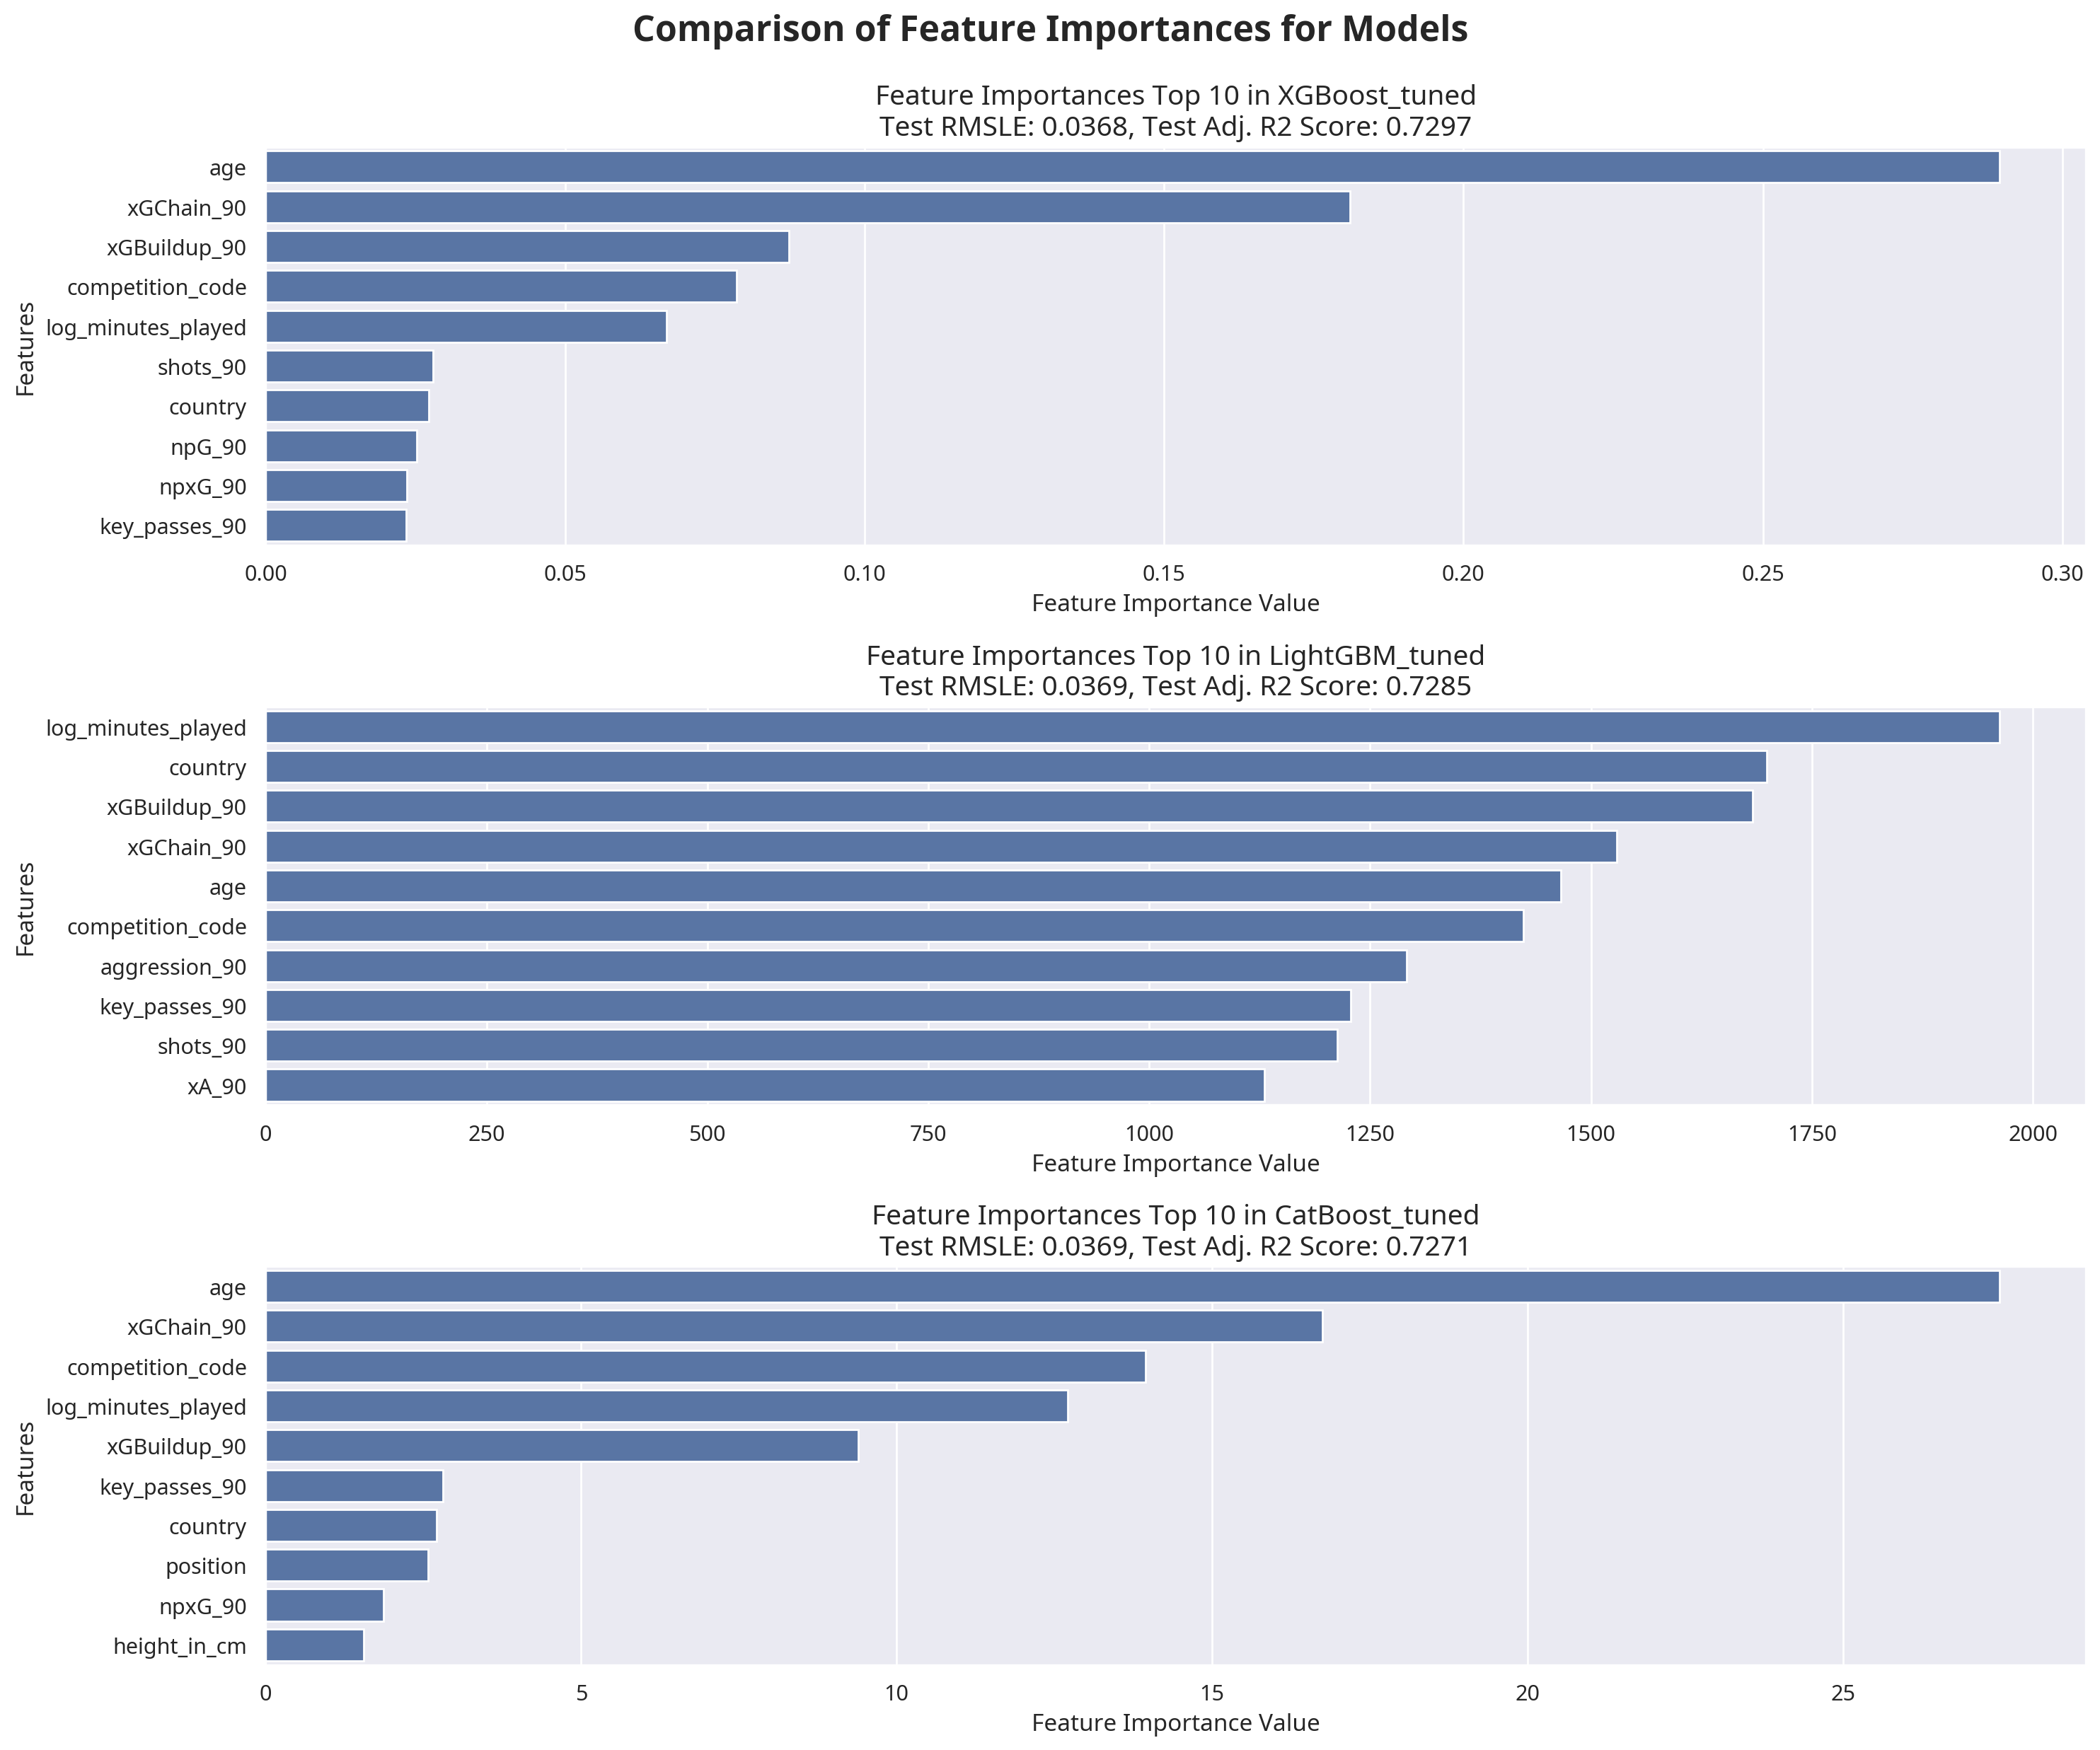

In [217]:
# feature importance 파악

# Feature importance 데이터
xgb_importance_values = loaded_models["XGBoost_tuned"].feature_importances_
lgb_importance_values = loaded_models["LightGBM_tuned"].feature_importances_
cat_importance_values = loaded_models["CatBoost_tuned"].feature_importances_

feature_importances_dict = {
    "XGBoost_tuned": xgb_importance_values,
    "LightGBM_tuned": lgb_importance_values,
    "CatBoost_tuned": cat_importance_values 
}

nrows, ncols = (3, 1)  # 행과 열의 수 설정
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 13))  # 서브플롯 생성

# 서브플롯 배열을 1차원으로 펴기
axes = axes.flatten()

# Feature importance 시각화
for i, (key, value) in enumerate(feature_importances_dict.items()):
    # 정렬과 시각화를 쉽게 하기 위해 series 전환
    values_series = pd.Series(value, index=X_train.columns)
    values_top10 = values_series.sort_values(ascending=False)[:10]

    sns.barplot(x=values_top10, y=values_top10.index, ax=axes[i])  # 각 subplot에 배치
    
    # Test RMSLE 값 추출
    test_rmsle = results_df_tuned.loc[results_df_tuned["Model"] == key, "Test RMSLE"].values[0]
    
    # Test Adjusted R2 값 추출
    test_adj_r2 = results_df_tuned.loc[results_df_tuned["Model"] == key, "Test Adjusted R2"].values[0]    
    
    # 제목 설정
    axes[i].set_title(f'Feature Importances Top 10 in {key}\nTest RMSLE: {test_rmsle:.4f}, Test Adj. R2 Score: {test_adj_r2:.4f}', fontsize=14)
    axes[i].set_xlabel("Feature Importance Value")  # x축 이름
    axes[i].set_ylabel("Features")  # y축 이름

plt.suptitle("Comparison of Feature Importances for Models", fontsize=18, fontweight="bold")
plt.tight_layout(rect=[0, 0.03, 1, 0.99])  # 제목 공간 확보를 위한 조정
plt.show()

## 7. 예측 값과 실제 값 비교

### 7-1. XGBoost 모델로 예측한 test 값을 y_test 값과 비교

In [226]:
# test 데이터프레임 copy
test_copy_xgb = test.copy()

# xgb_optuna 모델로 예측한 X_test의 몸값을 담은 컬럼을 test_copy에 생성
test_copy_xgb["log_market_value_pred"] = loaded_models["XGBoost_tuned"].predict(X_test)

In [227]:
df_original.columns

Index(['player_name', 'start_season', 'yellow_cards', 'red_cards', 'goals',
       'assists', 'minutes_played', 'competition_code', 'date_of_birth',
       'position', 'team_title', 'market_value_per_season', 'country', 'foot',
       'height_in_cm', 'xA', 'shots', 'key_passes', 'npG', 'npxG', 'xGChain',
       'xGBuildup', 'age', 'aggression', 'goals_90', 'assists_90',
       'aggression_90', 'npG_90', 'npxG_90', 'xA_90', 'shots_90',
       'key_passes_90', 'xGChain_90', 'xGBuildup_90', 'npG_per_shot',
       'npxG_per_shot', 'goal_conv', 'npG_conv', 'npG_vs_npxG',
       'position_category', 'log_market_value_per_season',
       'log_minutes_played'],
      dtype='object')

In [228]:
# 모델링할 때 player_name을 제거했기 때문에 다시 병합해준다 (선수 이름 확인용)
test_copy_xgb = pd.merge(test_copy_xgb, df_original[["player_name", "team_title"]], left_index=True, right_index=True, how="left")

# "player_name"을 가장 왼쪽으로 이동
cols = ["player_name"] + [col for col in test_copy_xgb.columns if col != "player_name"]
test_copy_xgb = test_copy_xgb[cols]
test_copy_xgb.head(3)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title
1052,Adrian Beck,2023,6.879356,bundesliga,Attacking Midfield,Germany,right,186.0,26,0.092688,0.027806,0.092688,0.091997,0.098228,1.112255,1.019567,0.130869,0.085232,0.083333,Midfielder,14.220976,14.161222,FC Heidenheim
1053,Alassane Plea,2023,7.563720,bundesliga,Centre-Forward,France,right,181.0,31,0.233645,0.014019,0.280374,0.286068,0.170204,2.710280,1.682243,0.638446,0.272400,0.103448,Forward,15.761421,15.966929,Borussia M.Gladbach
1054,Alejandro Grimaldo,2023,7.933438,bundesliga,Left-Back,Spain,left,171.0,28,0.484218,0.009684,0.322812,0.176935,0.343490,2.291966,2.517934,0.716462,0.445019,0.140845,Defender,17.622173,17.684734,Bayer Leverkusen


In [229]:
# market_value_per_season의 로그 변환을 되돌림
test_copy_xgb["market_value_original"] = np.expm1(test_copy_xgb["log_market_value_per_season"])
test_copy_xgb["market_value_pred"] = np.expm1(test_copy_xgb["log_market_value_pred"])

In [230]:
test_copy_xgb.head(3)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title,market_value_original,market_value_pred
1052,Adrian Beck,2023,6.879356,bundesliga,Attacking Midfield,Germany,right,186.0,26,0.092688,0.027806,0.092688,0.091997,0.098228,1.112255,1.019567,0.130869,0.085232,0.083333,Midfielder,14.220976,14.161222,FC Heidenheim,1500000.0,1412994.5
1053,Alassane Plea,2023,7.563720,bundesliga,Centre-Forward,France,right,181.0,31,0.233645,0.014019,0.280374,0.286068,0.170204,2.710280,1.682243,0.638446,0.272400,0.103448,Forward,15.761421,15.966929,Borussia M.Gladbach,7000000.0,8597047.0
1054,Alejandro Grimaldo,2023,7.933438,bundesliga,Left-Back,Spain,left,171.0,28,0.484218,0.009684,0.322812,0.176935,0.343490,2.291966,2.517934,0.716462,0.445019,0.140845,Defender,17.622173,17.684734,Bayer Leverkusen,45000000.0,47905188.0


In [231]:
# calculate_rmsle 함수 활용하여, 실제 몸값과 예측 몸값의 차이 RMSLE 계산한 컬럼 생성

test_copy_xgb['market_value_diff_rmsle'] = test_copy_xgb.apply(lambda x:calculate_rmsle(x["market_value_original"], x["market_value_pred"]), axis=1)

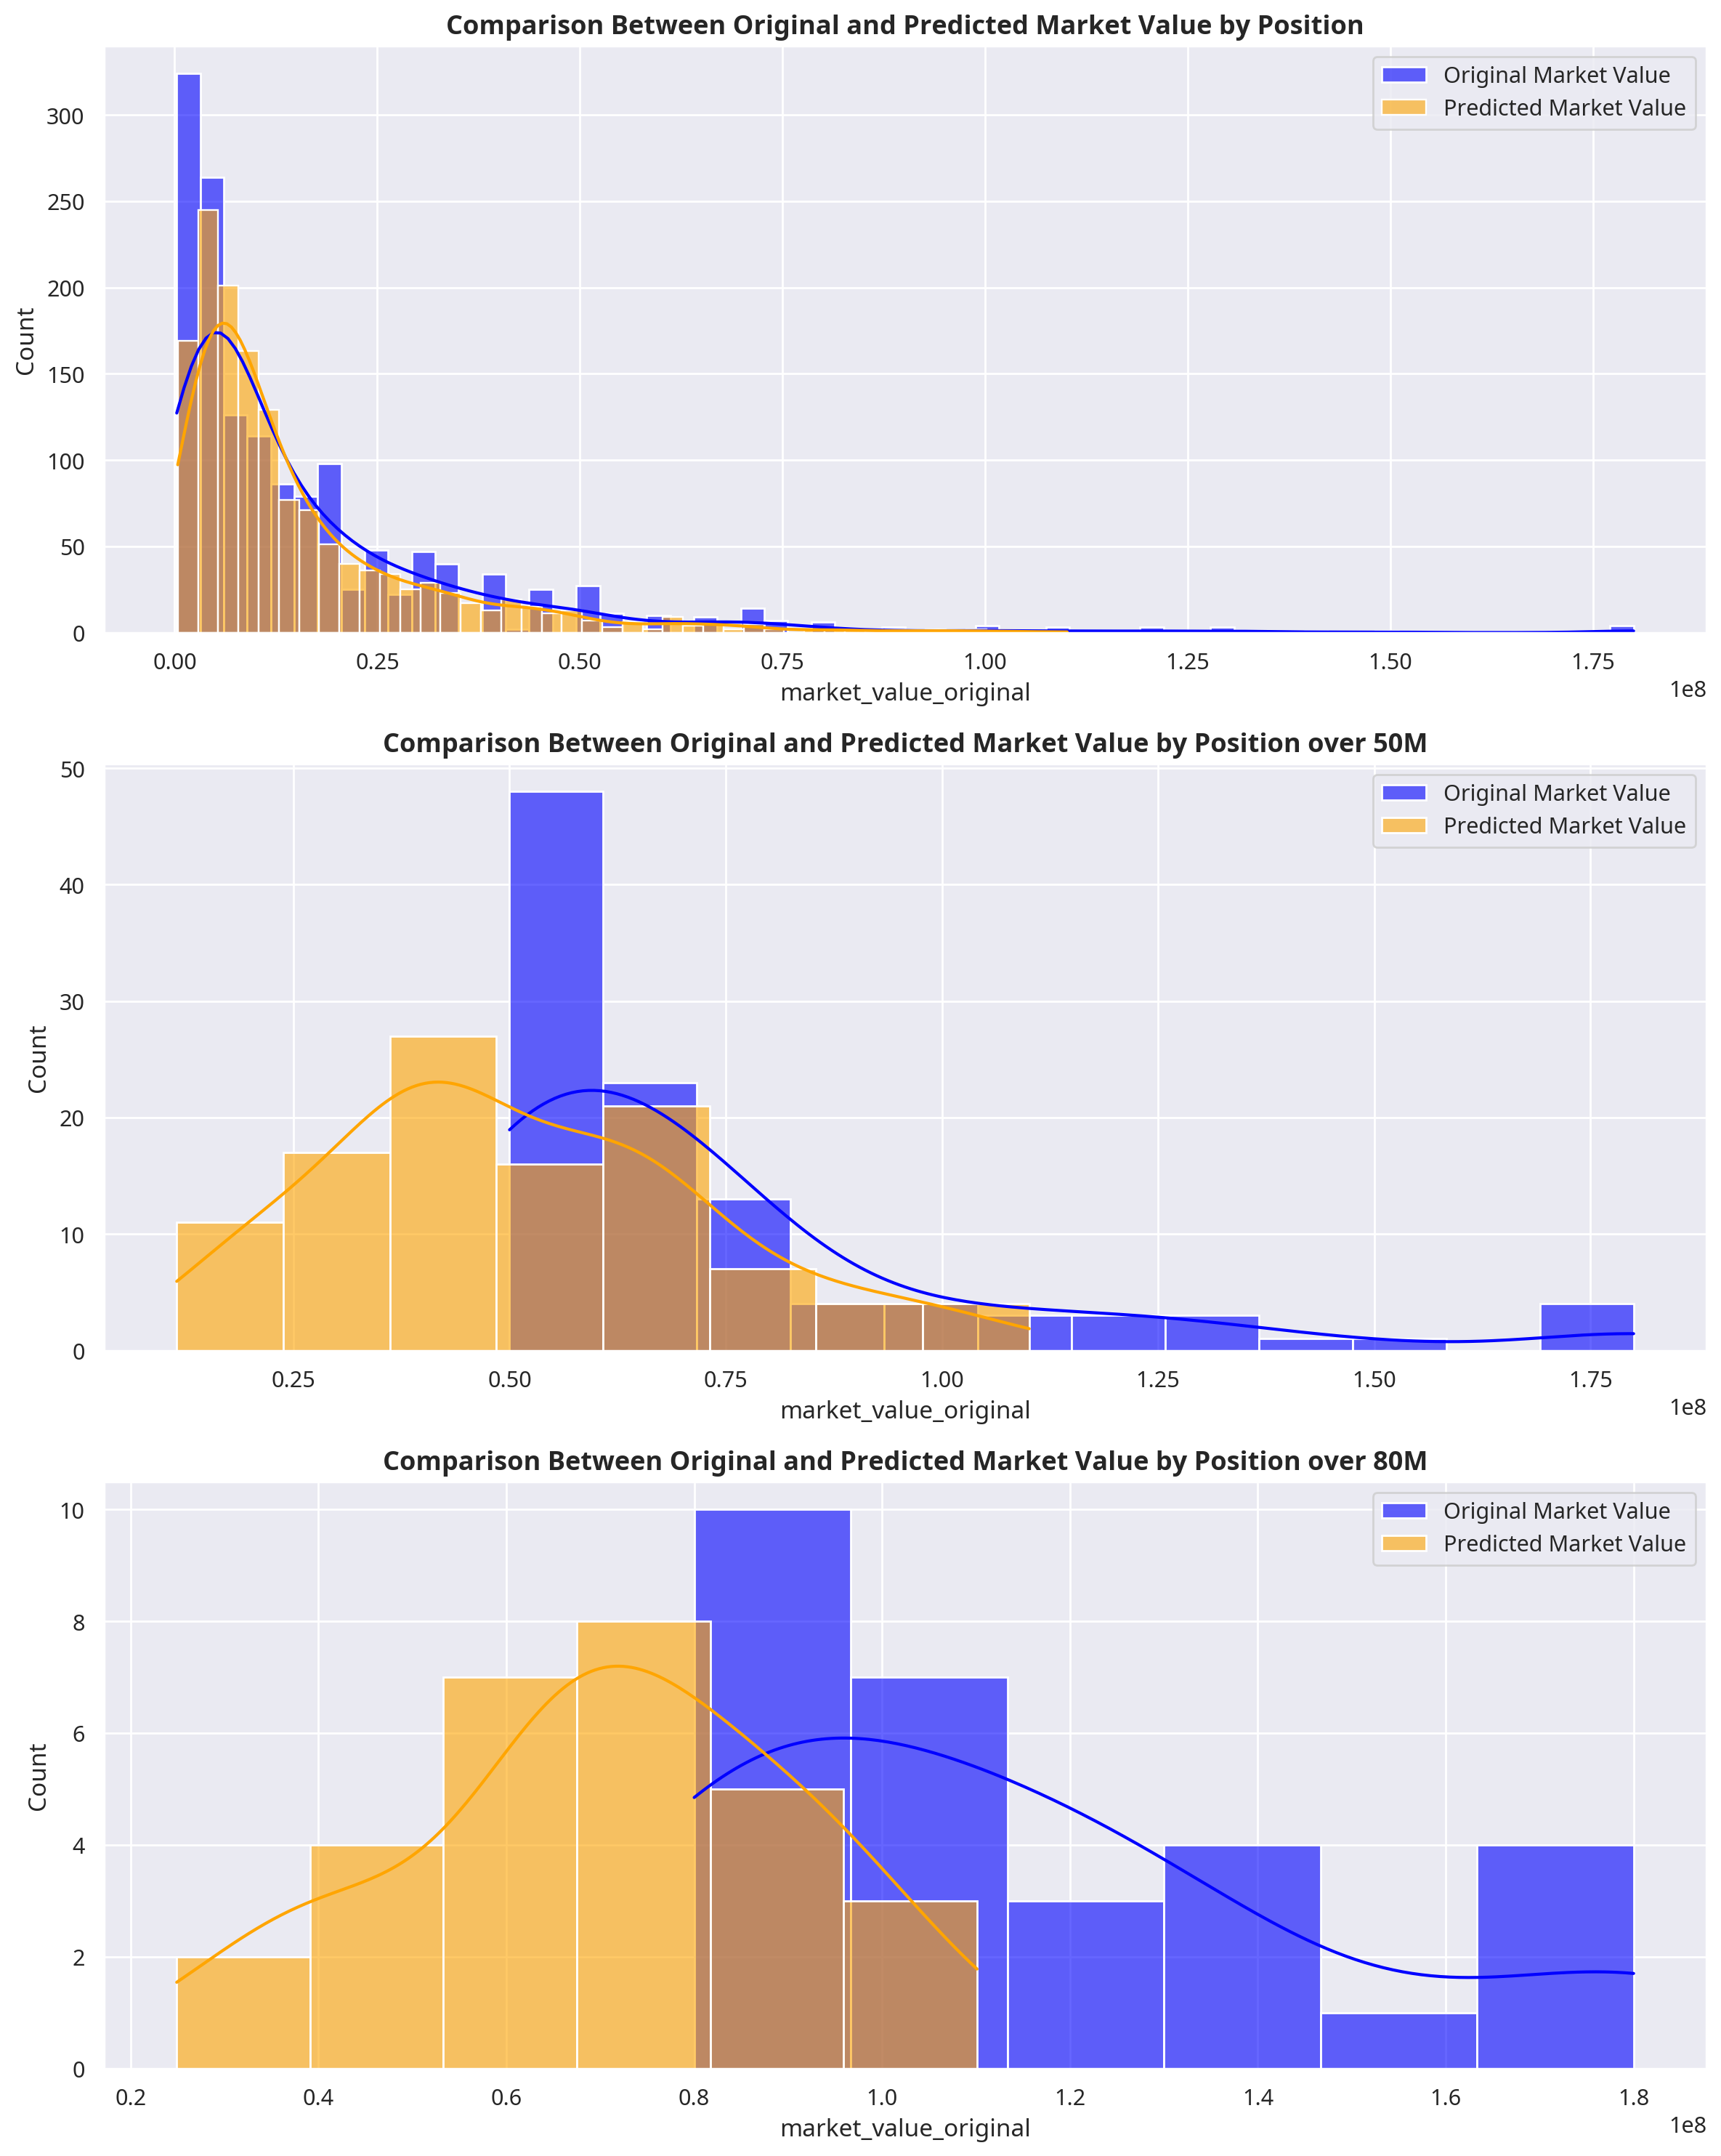

In [255]:
# 실제 값, 예측 값 비교 시각화
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

sns.histplot(test_copy_xgb, x="market_value_original", color='blue', 
             label='Original Market Value', kde=True, alpha=0.6, ax=axes[0])
sns.histplot(test_copy_xgb, x="market_value_pred", color='orange', 
             label='Predicted Market Value', kde=True, alpha=0.6, ax=axes[0])
axes[0].set_title("Comparison Between Original and Predicted Market Value by Position", fontsize=13, fontweight="bold")
axes[0].legend()

sns.histplot(test_copy_xgb[test_copy_xgb["market_value_original"]>=50000000], x="market_value_original", color='blue', 
             label='Original Market Value', kde=True, alpha=0.6, ax=axes[1])
sns.histplot(test_copy_xgb[test_copy_xgb["market_value_original"]>=50000000], x="market_value_pred", color='orange', 
             label='Predicted Market Value', kde=True, alpha=0.6, ax=axes[1])
axes[1].set_title("Comparison Between Original and Predicted Market Value by Position over 50M", fontsize=13, fontweight="bold")
axes[1].legend()


sns.histplot(test_copy_xgb[test_copy_xgb["market_value_original"]>=80000000], x="market_value_original", color='blue', 
             label='Original Market Value', kde=True, alpha=0.6, ax=axes[2])
sns.histplot(test_copy_xgb[test_copy_xgb["market_value_original"]>=80000000], x="market_value_pred", color='orange', 
             label='Predicted Market Value', kde=True, alpha=0.6, ax=axes[2])
axes[2].set_title("Comparison Between Original and Predicted Market Value by Position over 80M", fontsize=13, fontweight="bold")
axes[2].legend()

plt.tight_layout()
plt.show()

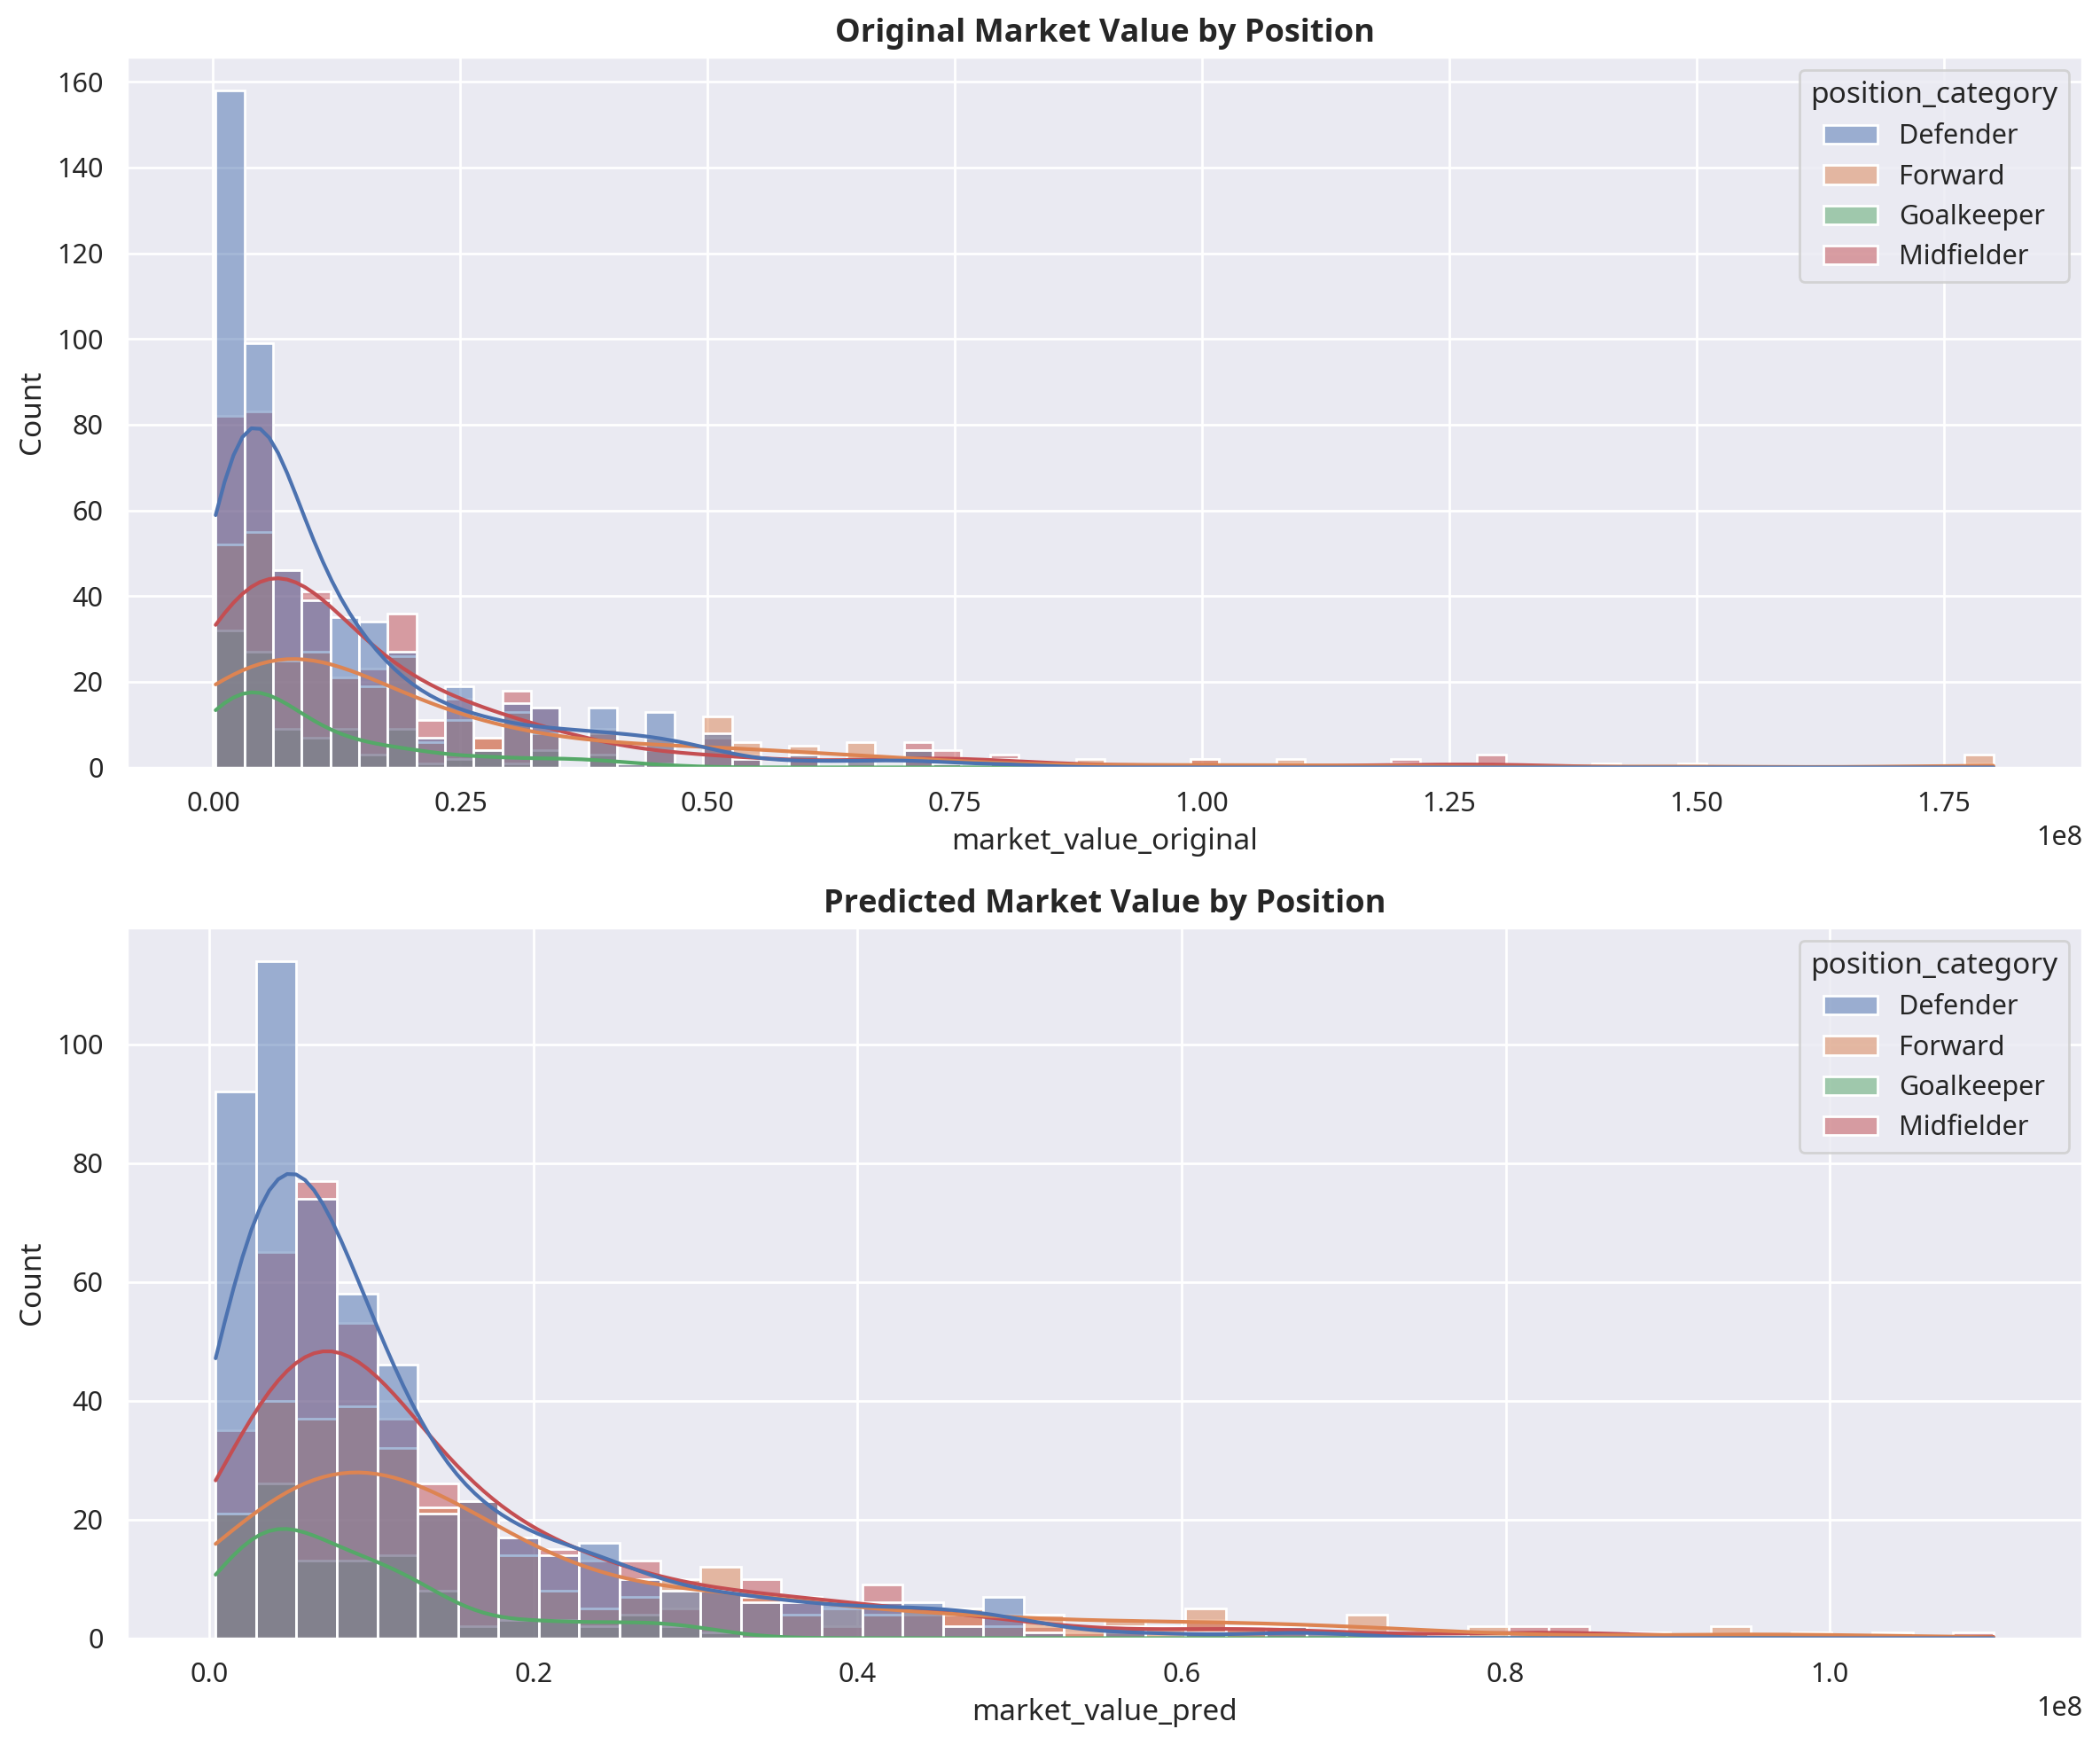

In [246]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

sns.histplot(data=test_copy_xgb, x="market_value_original", kde=True, hue="position_category", ax=axes[0])
axes[0].set_title("Original Market Value by Position", fontsize=13, fontweight="bold")

sns.histplot(data=test_copy_xgb, x="market_value_pred", kde=True, hue="position_category", ax=axes[1])
axes[1].set_title("Predicted Market Value by Position", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.show()

In [256]:
# RMSLE 값 작은 순서대로 Top 10
test_copy_xgb.sort_values(by="market_value_diff_rmsle", ascending=True).head(10)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title,market_value_original,market_value_pred,market_value_diff_rmsle
5294,Antonio Rüdiger,2023,7.903966,laliga,Centre-Back,Germany,right,190.0,31,0.033247,0.069819,0.033247,0.060763,0.036929,0.631696,0.166236,0.621550,0.591774,0.052632,Defender,17.034386,17.032564,Real Madrid,25000000.0,24954484.0,0.001822
2411,Mathías Olivera,2023,7.360740,serie-a,Left-Back,Uruguay,left,185.0,26,0.057252,0.051527,0.057252,0.046523,0.063377,0.687023,1.087786,0.437973,0.371265,0.083333,Defender,16.523561,16.520741,Napoli,15000000.0,14957755.0,0.002820
2438,Natan,2023,6.862758,serie-a,Centre-Back,Brazil,left,188.0,23,0.000000,0.084817,0.000000,0.024063,0.012906,0.565445,0.376963,0.383027,0.370983,0.000000,Defender,16.300417,16.303831,Napoli,12000000.0,12041036.0,0.003414
4055,Pervis Estupiñán,2023,7.127694,premier-league,Left-Back,Ecuador,left,175.0,26,0.216867,0.086747,0.144578,0.074754,0.237568,0.795181,1.879518,0.587815,0.430127,0.181818,Defender,17.216708,17.222015,Brighton,30000000.0,30159644.0,0.005307
1230,Mattias Svanberg,2023,7.454141,bundesliga,Central Midfield,Sweden,right,185.0,25,0.208575,0.125145,0.052144,0.148930,0.147511,2.190035,1.355736,0.434286,0.240049,0.023810,Midfielder,16.300417,16.305832,Wolfsburg,12000000.0,12065152.0,0.005415
2280,Darko Lazović,2023,7.573531,serie-a,Left Midfield,Serbia,right,181.0,33,0.092545,0.032391,0.092545,0.109430,0.167637,1.573265,1.434447,0.324978,0.114052,0.058824,Midfielder,14.220976,14.213844,Verona,1500000.0,1489340.0,0.007132
3969,Keane Lewis-Potter,2023,7.273786,premier-league,Left Winger,England,right,170.0,23,0.062457,0.000000,0.187370,0.535988,0.100846,2.685635,0.811936,0.583654,0.078622,0.069767,Forward,16.523561,16.515051,Brentford,15000000.0,14872893.0,0.008510
6700,Ainsley Maitland-Niles,2023,7.267525,ligue-1,Right-Back,England,right,180.0,26,0.251397,0.062849,0.000000,0.154542,0.120273,1.131285,1.131285,0.395077,0.335532,0.000000,Defender,16.012735,16.021692,Lyon,9000000.0,9080975.0,0.008957
6934,Warmed Omari,2023,7.636270,ligue-1,Centre-Back,France,right,188.0,24,0.000000,0.095606,0.043457,0.028177,0.012364,0.130372,0.217286,0.249918,0.247760,0.333333,Defender,15.894952,15.884595,Rennes,8000000.0,7917569.0,0.010357
6750,Duje Caleta-Car,2023,7.597396,ligue-1,Centre-Back,Croatia,right,193.0,27,0.000000,0.058735,0.000000,0.028436,0.055143,0.316265,0.316265,0.354027,0.353580,0.000000,Defender,15.761421,15.750783,Lyon,7000000.0,6925929.5,0.010638


In [257]:
# RMSLE 값 큰 순서대로 Top 10
test_copy_xgb.sort_values(by="market_value_diff_rmsle", ascending=False).head(10)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title,market_value_original,market_value_pred,market_value_diff_rmsle
4043,Oliver Arblaster,2023,6.853299,premier-league,Central Midfield,England,right,180.0,20,0.000000,0.057082,0.000000,0.002067,0.097967,0.095137,1.141649,0.274113,0.251627,0.000000,Midfielder,13.017005,16.102812,Sheffield United,450000.0,9848323.0,3.085807
5290,André Ferreira,2023,7.200425,laliga,Goalkeeper,Portugal,right,193.0,28,0.000000,0.020164,0.000000,0.000000,0.000000,0.000000,0.000000,0.153897,0.153897,0.000000,Goalkeeper,13.592368,15.970533,Granada,800000.0,8628086.0,2.378165
5451,Mikel Oyarzabal,2023,7.678326,laliga,Centre-Forward,Spain,left,181.0,27,0.125000,0.037500,0.291667,0.360673,0.091296,1.666667,0.875000,0.438577,0.054798,0.175000,Forward,17.622173,15.703771,Real Sociedad,45000000.0,6607860.5,1.918402
3923,Jack Robinson,2023,7.967973,premier-league,Centre-Back,England,left,180.0,30,0.031185,0.093555,0.031185,0.047142,0.033912,0.436590,0.374220,0.120587,0.085005,0.071429,Defender,13.815512,15.729966,Sheffield United,1000000.0,6783244.0,1.914455
1303,Sven Ulreich,2023,6.898715,bundesliga,Goalkeeper,Germany,right,192.0,35,0.000000,0.027273,0.000000,0.000000,0.006560,0.000000,0.090909,0.434387,0.427827,0.000000,Goalkeeper,13.458837,15.322557,Bayern Munich,700000.0,4513381.5,1.863720
4064,Reece Burke,2023,7.417580,premier-league,Centre-Back,England,right,189.0,27,0.216346,0.081130,0.000000,0.117070,0.125559,0.703125,0.703125,0.224157,0.209211,0.000000,Defender,14.403298,16.250542,Luton,1800000.0,11416173.0,1.847244
1268,Pascal Stenzel,2023,6.977281,bundesliga,Right-Back,Germany,right,183.0,28,0.420168,0.075630,0.000000,0.027452,0.264408,1.176471,1.260504,0.758194,0.590201,0.000000,Defender,14.731802,16.569538,VfB Stuttgart,2500000.0,15705760.0,1.837736
3833,Ben Osborn,2023,7.218177,premier-league,Central Midfield,England,left,176.0,29,0.132062,0.059428,0.000000,0.011825,0.071041,0.264123,0.858401,0.202749,0.135048,0.000000,Midfielder,13.815512,15.643335,Sheffield United,1000000.0,6220340.5,1.827824
3952,Jordan Clark,2023,7.175490,premier-league,Central Midfield,England,right,183.0,30,0.068913,0.082695,0.068913,0.063834,0.127387,1.171516,0.826953,0.301421,0.179655,0.058824,Midfielder,13.815512,15.600138,Luton,1000000.0,5957357.5,1.784626
6788,Habib Keïta,2023,7.150701,ligue-1,Central Midfield,Mali,left,182.0,22,0.000000,0.084772,0.070644,0.045104,0.048688,1.412873,0.706436,0.339799,0.286546,0.050000,Midfielder,13.815512,15.589372,Clermont Foot,1000000.0,5893564.5,1.773860


In [240]:
# Arsenal 선수들의 2324 시즌 몸값 비교
test_copy_xgb[test_copy_xgb.team_title=="Arsenal"].sort_values("market_value_diff_rmsle").head(10)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title,market_value_original,market_value_pred,market_value_diff_rmsle
3977,Leandro Trossard,2023,7.406711,premier-league,Left Winger,Belgium,right,172.0,29,0.054678,0.032807,0.656136,0.523584,0.177817,3.280680,1.312272,0.928240,0.300886,0.200000,Forward,17.370859,17.465357,Arsenal,35000000.0,38468752.0,0.094498
3871,David Raya,2023,7.965893,premier-league,Goalkeeper,Spain,right,183.0,28,0.000000,0.018750,0.000000,0.000000,0.000000,0.000000,0.000000,0.234925,0.234925,0.000000,Goalkeeper,17.370859,17.218739,Arsenal,35000000.0,30060980.0,0.152120
4109,William Saliba,2023,8.137688,premier-league,Centre-Back,France,right,192.0,23,0.026316,0.031579,0.052632,0.062295,0.006550,0.263158,0.157895,0.437678,0.432495,0.200000,Defender,18.197537,18.040831,Arsenal,80000000.0,68396392.0,0.156707
3927,Jakub Kiwior,2023,6.852243,premier-league,Left-Back,Poland,left,189.0,24,0.285714,0.028571,0.095238,0.113921,0.086479,0.571429,0.571429,0.493339,0.380055,0.166667,Defender,17.216708,17.052210,Arsenal,30000000.0,25449580.0,0.164498
3967,Kai Havertz,2023,7.878913,premier-league,Attacking Midfield,Germany,left,193.0,24,0.238636,0.112500,0.409091,0.433110,0.198217,2.352273,1.534091,0.845118,0.318618,0.173913,Midfielder,18.064006,18.246445,Arsenal,70000000.0,84009856.0,0.182439
3834,Ben White,2023,8.005033,premier-league,Right-Back,England,right,186.0,26,0.120200,0.072120,0.120200,0.060578,0.143003,0.390651,1.141903,0.605488,0.519579,0.307692,Defender,17.822844,17.615313,Arsenal,55000000.0,44692336.0,0.207531
3902,Gabriel Magalhães,2023,8.021256,premier-league,Centre-Back,Brazil,left,190.0,26,0.000000,0.035480,0.088699,0.119015,0.025864,0.916557,0.088699,0.391234,0.364649,0.096774,Defender,18.064006,17.851826,Arsenal,70000000.0,56617332.0,0.212180
3903,Gabriel Martinelli,2023,7.615791,premier-league,Left Winger,Brazil,right,178.0,22,0.177427,0.013307,0.266141,0.315806,0.236108,2.572696,2.040414,0.745593,0.294456,0.103448,Forward,18.064006,17.768858,Arsenal,70000000.0,52109508.0,0.295148
4003,Martin Ødegaard,2023,8.040769,premier-league,Attacking Midfield,Norway,left,178.0,25,0.289948,0.017397,0.173969,0.178258,0.335685,2.232603,2.957474,0.864483,0.525909,0.077922,Midfielder,18.515991,18.209505,Arsenal,110000000.0,80963184.0,0.306486
3886,Eddie Nketiah,2023,6.978214,premier-league,Centre-Forward,England,right,175.0,25,0.167910,0.075560,0.419776,0.424596,0.101556,3.190299,0.755597,0.491234,0.083209,0.131579,Forward,17.216708,16.870062,Arsenal,30000000.0,21211664.0,0.346646


In [242]:
# Tottenham 선수들의 2324 시즌 몸값 비교
test_copy_xgb[test_copy_xgb.team_title=="Tottenham"].sort_values("market_value_diff_rmsle").head(10)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title,market_value_original,market_value_pred,market_value_diff_rmsle
3874,Dejan Kulusevski,2023,7.925519,premier-league,Right Winger,Sweden,left,186.0,24,0.097614,0.068330,0.260304,0.189874,0.280334,1.854664,2.114967,0.771707,0.406961,0.140351,Forward,17.822844,17.843367,Tottenham,55000000.0,56140420.0,0.020523
4115,Yves Bissouma,2023,7.642044,premier-league,Defensive Midfield,Mali,right,182.0,27,0.000000,0.159866,0.000000,0.050395,0.017495,1.036966,0.432069,0.486424,0.457552,0.000000,Midfielder,17.370859,17.334675,Tottenham,35000000.0,33756204.0,0.036184
3863,Cristian Romero,2023,7.934872,premier-league,Centre-Back,Argentina,right,185.0,26,0.000000,0.090258,0.161175,0.128460,0.011020,0.773639,0.225645,0.574159,0.530393,0.208333,Defender,17.989898,17.918568,Tottenham,65000000.0,60525036.0,0.071330
3914,Heung-min Son,2023,7.989221,premier-league,Left Winger,"Korea, South",both,184.0,31,0.305292,0.009159,0.457938,0.349751,0.407290,2.594980,2.106513,0.919404,0.318907,0.176471,Forward,17.622173,17.694683,Tottenham,45000000.0,48384160.0,0.072510
4053,Pedro Porro,2023,8.037220,premier-league,Right-Back,Spain,right,173.0,24,0.203686,0.026188,0.087294,0.082495,0.211985,1.542192,1.513094,0.588821,0.459578,0.056604,Defender,17.622173,17.699343,Tottenham,45000000.0,48610140.0,0.077170
3875,Destiny Udogie,2023,7.782807,premier-league,Left-Back,Italy,left,188.0,21,0.112594,0.078816,0.075063,0.105609,0.095722,0.337781,0.900751,0.557302,0.409339,0.222222,Defender,17.622173,17.522697,Tottenham,45000000.0,40739040.0,0.099476
4068,Rodrigo Bentancur,2023,6.915723,premier-league,Central Midfield,Uruguay,right,187.0,26,0.089374,0.187686,0.089374,0.145018,0.045019,1.608739,0.714995,0.766525,0.660432,0.055556,Midfielder,17.370859,17.257414,Tottenham,35000000.0,31246372.0,0.113445
3930,James Maddison,2023,7.675546,premier-league,Attacking Midfield,England,right,175.0,27,0.376045,0.062674,0.167131,0.263131,0.298428,2.381616,2.757660,0.872151,0.503104,0.070175,Midfielder,18.064006,17.938017,Tottenham,70000000.0,61713724.0,0.125989
4065,Richarlison,2023,7.308543,premier-league,Centre-Forward,Brazil,right,184.0,27,0.241287,0.054290,0.663539,0.580238,0.118691,3.679625,0.904826,0.768204,0.138056,0.180328,Forward,17.453097,17.265329,Tottenham,38000000.0,31494684.0,0.187767
4017,Micky van de Ven,2023,7.759614,premier-league,Centre-Back,Netherlands,left,193.0,23,0.000000,0.057618,0.115237,0.037295,0.001360,0.307298,0.038412,0.407395,0.400372,0.375000,Defender,17.822844,17.611401,Tottenham,55000000.0,44517840.0,0.211443


In [243]:
# Manchester City 선수들의 2324 시즌 몸값 비교
test_copy_xgb[test_copy_xgb.team_title=="Manchester City"].sort_values("market_value_diff_rmsle").head(10)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title,market_value_original,market_value_pred,market_value_diff_rmsle
3965,Jérémy Doku,2023,7.374629,premier-league,Left Winger,Belgium,right,173.0,22,0.508156,0.050816,0.169385,0.212852,0.309187,3.161857,2.540778,0.825604,0.434883,0.053571,Forward,17.989898,17.926586,Manchester City,65000000.0,61012308.0,0.063312
3994,Manuel Akanji,2023,7.830028,premier-league,Centre-Back,Switzerland,right,188.0,28,0.000000,0.042959,0.071599,0.078773,0.018850,0.536993,0.465394,0.597886,0.567032,0.133333,Defender,17.622173,17.557476,Manchester City,45000000.0,42180816.0,0.064697
3963,Julián Álvarez,2023,7.886081,premier-league,Centre-Forward,Argentina,right,170.0,24,0.304626,0.020308,0.304626,0.434980,0.197097,3.317036,2.233923,0.919368,0.443038,0.091837,Forward,18.315320,18.192083,Manchester City,90000000.0,79564880.0,0.123237
3887,Ederson,2023,7.933438,premier-league,Goalkeeper,Brazil,left,188.0,30,0.000000,0.048422,0.000000,0.000000,0.000000,0.000000,0.000000,0.259348,0.259348,0.000000,Goalkeeper,17.370859,17.230434,Manchester City,35000000.0,30414632.0,0.140424
4074,Rúben Dias,2023,7.846981,premier-league,Centre-Back,Portugal,right,187.0,27,0.000000,0.000000,0.000000,0.064345,0.021136,0.703950,0.246382,0.591706,0.579300,0.000000,Defender,18.197537,18.019979,Manchester City,80000000.0,66985012.0,0.177558
3836,Bernardo Silva,2023,7.856707,premier-league,Attacking Midfield,Portugal,left,173.0,29,0.313710,0.083656,0.209140,0.142801,0.297276,1.185128,2.265686,0.849532,0.542972,0.176471,Midfielder,18.064006,17.855087,Manchester City,70000000.0,56802296.0,0.208918
4028,Nathan Aké,2023,7.623153,premier-league,Centre-Back,Netherlands,left,180.0,29,0.088063,0.000000,0.088063,0.095993,0.076475,0.880626,0.440313,0.581018,0.532001,0.100000,Defender,17.504390,17.250956,Manchester City,40000000.0,31045224.0,0.253434
4067,Rodri,2023,7.985825,premier-league,Defensive Midfield,Spain,right,191.0,27,0.275698,0.094963,0.245065,0.131547,0.163153,1.899251,1.531654,0.968710,0.805397,0.129032,Midfielder,18.683045,18.415337,Manchester City,130000000.0,99467008.0,0.267708
4005,Mateo Kovacic,2023,7.345365,premier-league,Central Midfield,Croatia,right,177.0,30,0.000000,0.069767,0.058140,0.083104,0.098000,1.279070,1.220930,0.785695,0.710831,0.045455,Midfielder,17.216708,16.917673,Manchester City,30000000.0,22246008.0,0.299035
3957,Josko Gvardiol,2023,7.753624,premier-league,Left-Back,Croatia,left,185.0,22,0.077286,0.034779,0.154573,0.119090,0.081753,1.236582,0.734221,0.705032,0.579442,0.125000,Defender,18.132999,17.707558,Manchester City,75000000.0,49011116.0,0.425441


In [258]:
# 몸값이 비싼 순서대로 market_value_diff_rmsle를 오름차순 정렬
test_copy_xgb.sort_values(by=["market_value_original", "market_value_diff_rmsle"], ascending=[False, True]).head(10)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title,market_value_original,market_value_pred,market_value_diff_rmsle
5413,Jude Bellingham,2023,7.751475,laliga,Attacking Midfield,England,right,186.0,20,0.232358,0.085198,0.697074,0.473671,0.228272,2.439759,1.858864,1.061969,0.599283,0.285714,Midfielder,19.008467,18.516943,Real Madrid,1.800000e+08,110104776.0,0.491524
6829,Kylian Mbappé,2023,7.677864,ligue-1,Centre-Forward,France,right,178.0,25,0.291802,0.050023,0.875405,0.634630,0.254753,5.002316,1.667439,1.138126,0.401098,0.175000,Forward,19.008467,18.363457,Paris Saint Germain,1.800000e+08,94438248.0,0.645011
5521,Vinicius Junior,2023,7.536897,laliga,Left Winger,Brazil,right,176.0,23,0.288000,0.100800,0.672000,0.732279,0.212812,3.744000,1.488000,0.984842,0.232084,0.179487,Forward,19.008467,18.047773,Real Madrid,1.800000e+08,68872904.0,0.960694
3894,Erling Haaland,2023,7.847372,premier-league,Centre-Forward,Norway,left,195.0,23,0.175919,0.010555,0.703675,0.899460,0.167185,4.292416,1.020328,1.062452,0.110077,0.163934,Forward,19.008467,17.902084,Manchester City,1.800000e+08,59535560.0,1.106383
4056,Phil Foden,2023,7.962764,premier-league,Right Winger,England,left,171.0,24,0.250784,0.018809,0.595611,0.354482,0.266967,3.291536,2.288401,0.953510,0.532884,0.180952,Forward,18.826146,18.365967,Manchester City,1.500000e+08,94675592.0,0.460179
3844,Bukayo Saka,2023,7.985144,premier-league,Right Winger,England,left,178.0,22,0.275886,0.036785,0.306540,0.375206,0.347186,3.279973,2.728202,0.930580,0.405509,0.093458,Forward,18.757153,18.410271,Arsenal,1.400000e+08,98964392.0,0.346882
4067,Rodri,2023,7.985825,premier-league,Defensive Midfield,Spain,right,191.0,27,0.275698,0.094963,0.245065,0.131547,0.163153,1.899251,1.531654,0.968710,0.805397,0.129032,Midfielder,18.683045,18.415337,Manchester City,1.300000e+08,99467008.0,0.267708
1145,Jamal Musiala,2023,7.477604,bundesliga,Attacking Midfield,Germany,right,184.0,21,0.305603,0.030560,0.509338,0.426554,0.318741,2.954160,2.088285,1.230858,0.574013,0.172414,Midfielder,18.683045,18.308823,Bayern Munich,1.300000e+08,89417112.0,0.374222
1129,Florian Wirtz,2023,7.776954,bundesliga,Attacking Midfield,Germany,right,177.0,21,0.453020,0.033977,0.377517,0.324645,0.335485,2.680369,2.718121,1.076738,0.574811,0.140845,Midfielder,18.683045,18.239790,Bayer Leverkusen,1.300000e+08,83452648.0,0.443255
5424,Lamine Yamal,2023,7.694848,laliga,Right Winger,Spain,left,180.0,16,0.286885,0.036885,0.204918,0.237413,0.274653,2.377049,1.598361,0.921121,0.493208,0.086207,Forward,18.603002,18.313143,Barcelona,1.200000e+08,89804240.0,0.289860


In [272]:
# 몸값이 싼 순서대로 market_value_diff_rmsle를 오름차순 정렬
test_copy_xgb.sort_values(by=["market_value_original", "market_value_diff_rmsle"], ascending=[True, True]).head(10)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title,market_value_original,market_value_pred,market_value_diff_rmsle
6795,Ismaël Traoré,2023,7.706163,ligue-1,Centre-Back,Cote d'Ivoire,right,184.0,37,0.000000,0.024313,0.081045,0.041670,0.003638,0.405223,0.081045,0.080531,0.079004,0.200000,Defender,12.429220,12.862206,Metz,250000.0,3.854643e+05,0.432986
6767,Florent Ogier,2023,6.848005,ligue-1,Centre-Back,France,right,183.0,35,0.095643,0.028693,0.095643,0.021874,0.054037,0.573858,0.095643,0.175086,0.175086,0.166667,Defender,12.611541,12.839356,Clermont Foot,300000.0,3.767563e+05,0.227815
1259,Norman Theuerkauf,2023,7.138073,bundesliga,Defensive Midfield,Germany,left,183.0,37,0.071542,0.064388,0.000000,0.040288,0.054490,0.500795,0.786963,0.194339,0.134925,0.000000,Midfielder,12.611541,12.907666,FC Heidenheim,300000.0,4.033919e+05,0.296125
2307,Federico Fazio,2023,7.213032,serie-a,Centre-Back,Argentina,right,195.0,37,0.000000,0.059735,0.066372,0.040368,0.008164,0.530973,0.199115,0.223815,0.213903,0.125000,Defender,12.899222,13.673380,Salernitana,400000.0,8.675069e+05,0.774158
1187,Klaus Gjasula,2023,7.220374,bundesliga,Defensive Midfield,Albania,both,190.0,34,0.000000,0.184480,0.000000,0.048073,0.014662,0.592972,0.395315,0.271725,0.247749,0.000000,Midfielder,12.899222,14.110096,Darmstadt,400000.0,1.342569e+06,1.210874
4043,Oliver Arblaster,2023,6.853299,premier-league,Central Midfield,England,right,180.0,20,0.000000,0.057082,0.000000,0.002067,0.097967,0.095137,1.141649,0.274113,0.251627,0.000000,Midfielder,13.017005,16.102812,Sheffield United,450000.0,9.848323e+06,3.085807
1066,Anthony Losilla,2023,7.858641,bundesliga,Defensive Midfield,France,right,185.0,38,0.069579,0.104368,0.034789,0.075051,0.055737,0.939312,0.660997,0.220860,0.129387,0.037037,Midfielder,13.122365,13.156467,Bochum,500000.0,5.173451e+05,0.034102
1091,Cristian Gamboa,2023,7.080026,bundesliga,Right-Back,Costa Rica,right,175.0,34,0.075821,0.159225,0.000000,0.005759,0.051961,0.454928,0.758214,0.236181,0.185504,0.000000,Defender,13.122365,13.315573,Bochum,500000.0,6.065674e+05,0.193207
6803,Johan Gastien,2023,7.729735,ligue-1,Defensive Midfield,France,right,179.0,36,0.000000,0.083113,0.000000,0.008659,0.081985,0.435356,1.266491,0.289083,0.246925,0.000000,Midfielder,13.122365,13.413851,Clermont Foot,500000.0,6.692074e+05,0.291485
3825,Ashley Young,2023,7.736744,premier-league,Left-Back,England,both,175.0,38,0.000000,0.082533,0.000000,0.022289,0.097197,0.510917,0.825328,0.267387,0.202794,0.000000,Defender,13.122365,13.559463,Everton,500000.0,7.741038e+05,0.437097


### 7-2. LightGBM 모델로 예측한 test 값을 y_test 값과 비교

In [260]:
# test 데이터프레임 copy
test_copy_lgb = test.copy()

# lgb_optuna 모델로 예측한 X_test의 몸값을 담은 컬럼을 test_copy에 생성
test_copy_lgb["log_market_value_pred"] = loaded_models["LightGBM_tuned"].predict(X_test)

In [261]:
# 모델링할 때 player_name을 제거했기 때문에 다시 병합해준다 (선수 이름 확인용)
test_copy_lgb = pd.merge(test_copy_lgb, df_original[["player_name", "team_title"]], left_index=True, right_index=True, how="left")

# "player_name"을 가장 왼쪽으로 이동
cols = ["player_name"] + [col for col in test_copy_lgb.columns if col != "player_name"]
test_copy_lgb = test_copy_lgb[cols]
test_copy_lgb.head(3)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title
1052,Adrian Beck,2023,6.879356,bundesliga,Attacking Midfield,Germany,right,186.0,26,0.092688,0.027806,0.092688,0.091997,0.098228,1.112255,1.019567,0.130869,0.085232,0.083333,Midfielder,14.220976,14.134602,FC Heidenheim
1053,Alassane Plea,2023,7.563720,bundesliga,Centre-Forward,France,right,181.0,31,0.233645,0.014019,0.280374,0.286068,0.170204,2.710280,1.682243,0.638446,0.272400,0.103448,Forward,15.761421,15.873078,Borussia M.Gladbach
1054,Alejandro Grimaldo,2023,7.933438,bundesliga,Left-Back,Spain,left,171.0,28,0.484218,0.009684,0.322812,0.176935,0.343490,2.291966,2.517934,0.716462,0.445019,0.140845,Defender,17.622173,17.604358,Bayer Leverkusen


In [262]:
# market_value_per_season의 로그 변환을 되돌림
test_copy_lgb["market_value_original"] = np.expm1(test_copy_lgb["log_market_value_per_season"])
test_copy_lgb["market_value_pred"] = np.expm1(test_copy_lgb["log_market_value_pred"])

In [263]:
# calculate_rmsle 함수 활용하여, 실제 몸값과 예측 몸값의 차이 RMSLE 계산한 컬럼 생성

test_copy_lgb['market_value_diff_rmsle'] = test_copy_lgb.apply(lambda x:calculate_rmsle(x["market_value_original"], x["market_value_pred"]), axis=1)

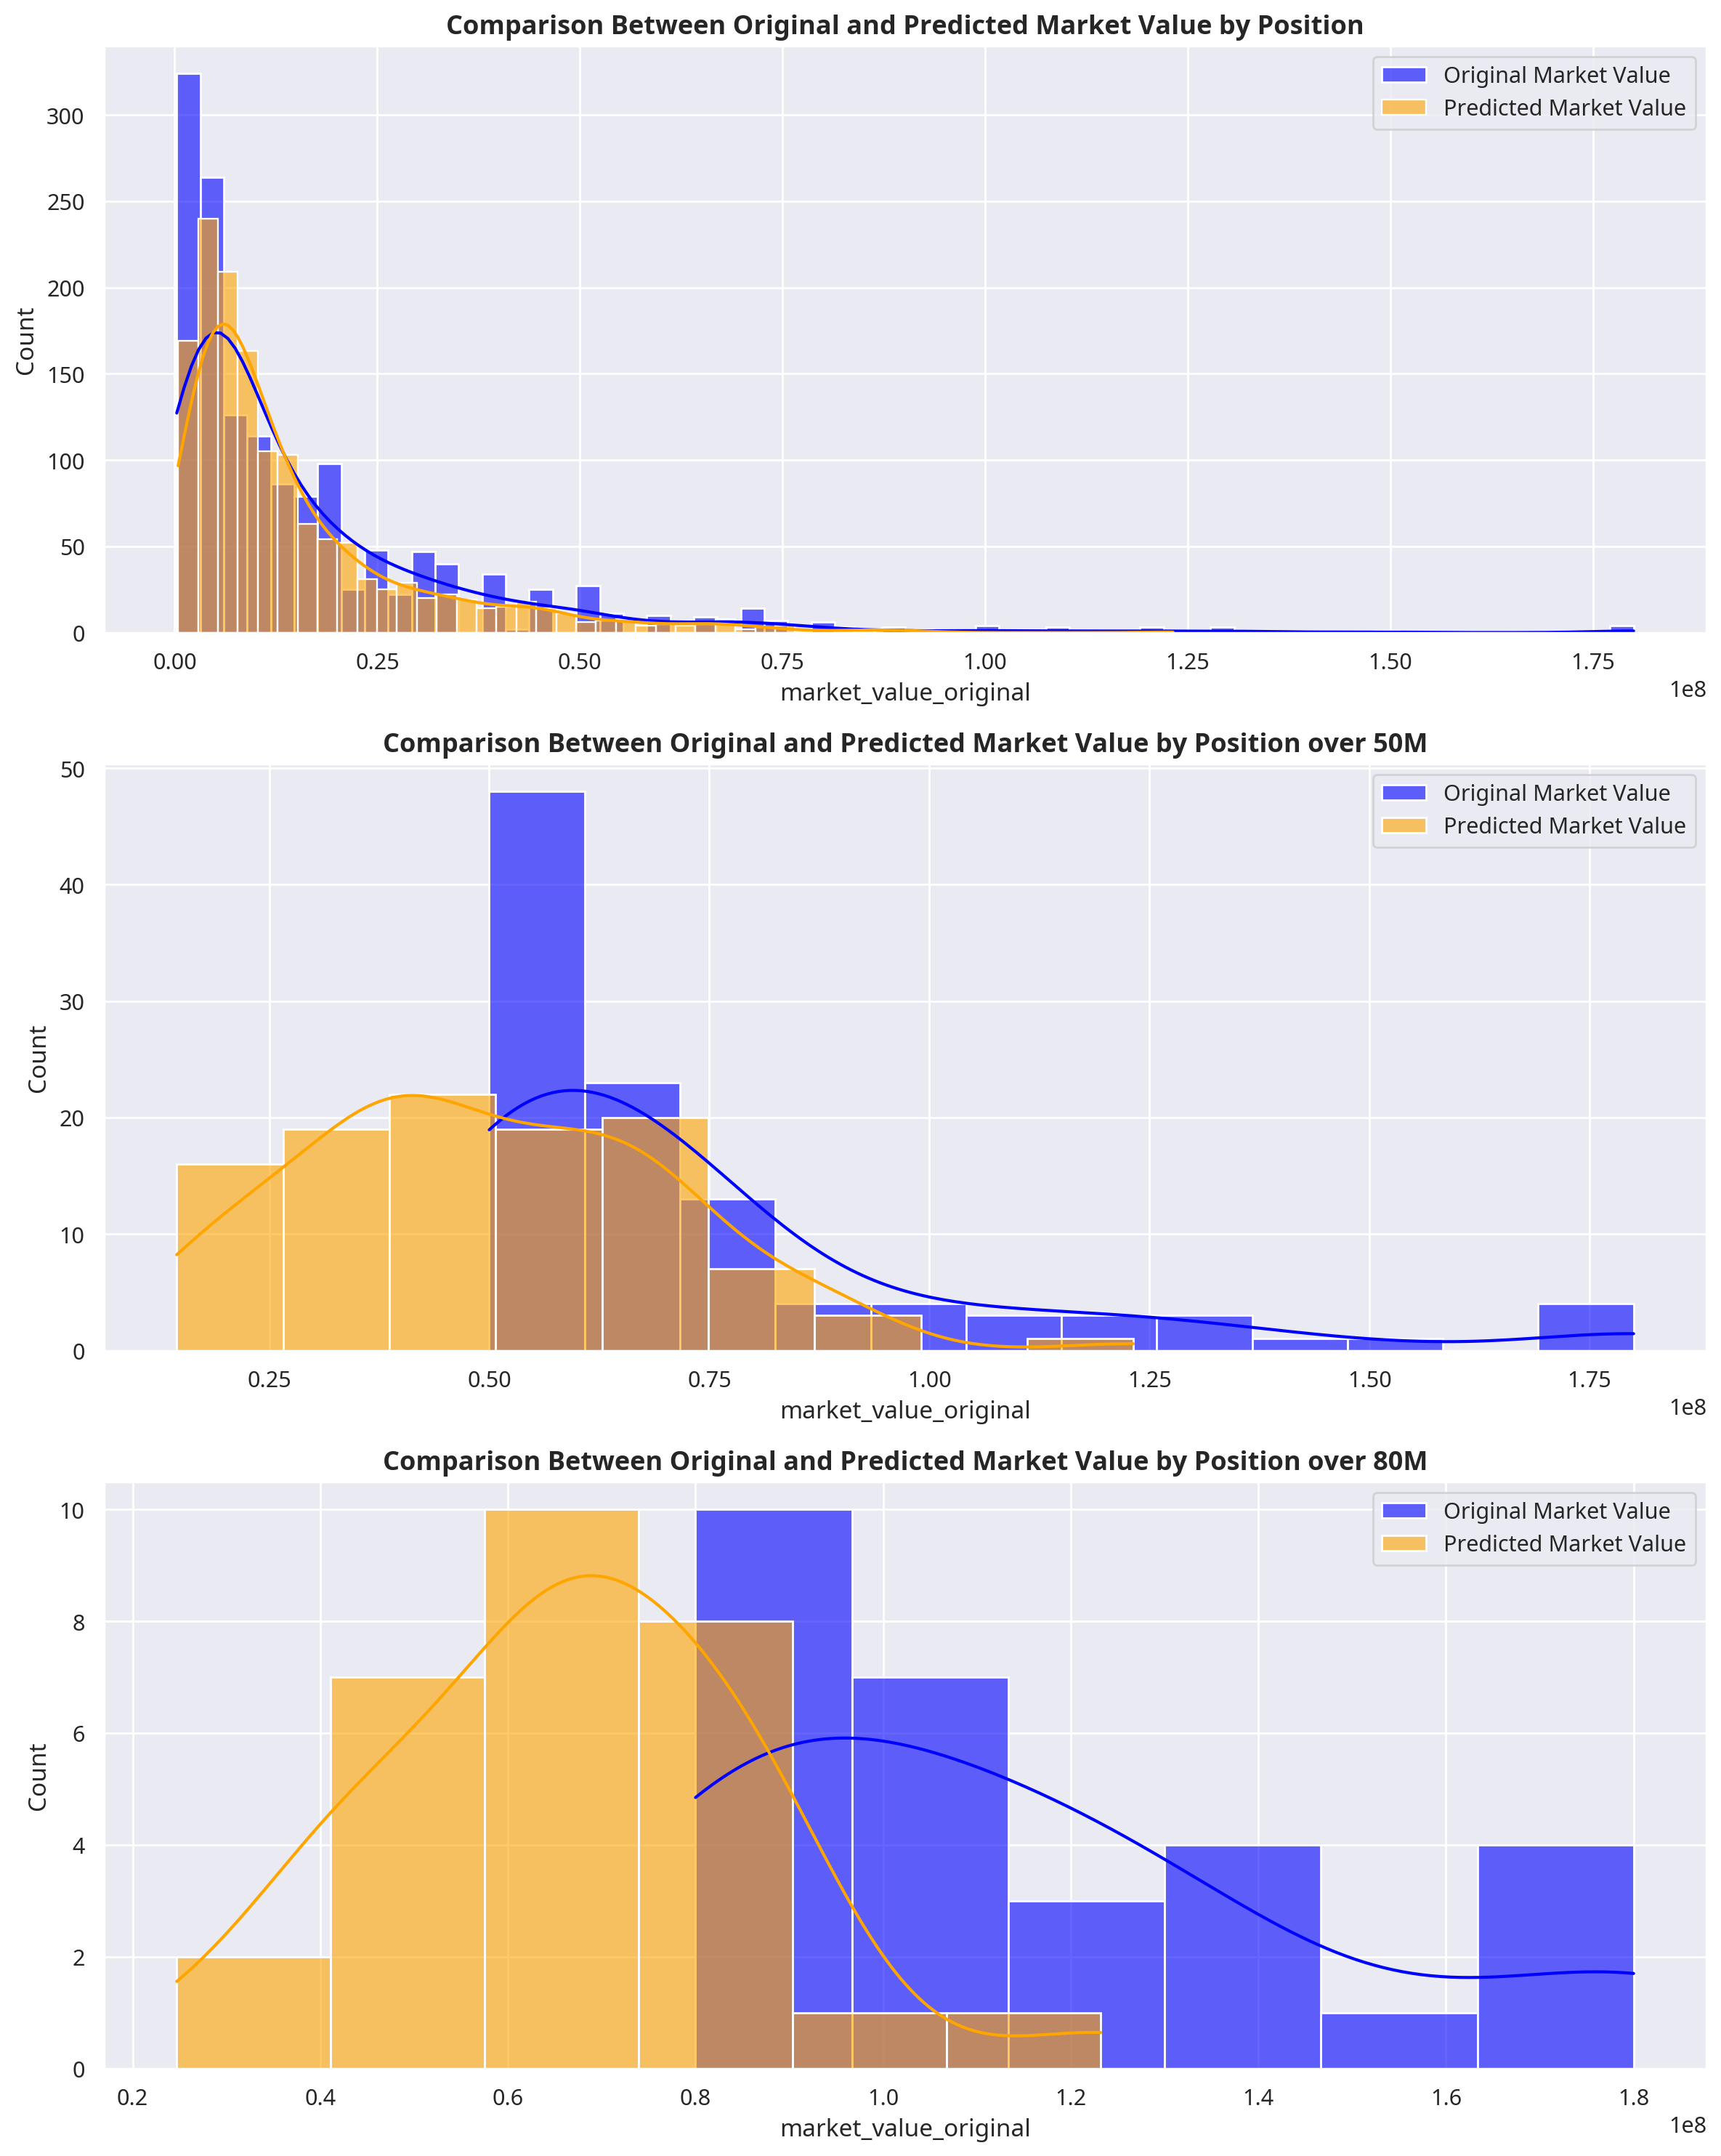

In [264]:
# 실제 값, 예측 값 비교 시각화
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

sns.histplot(test_copy_lgb, x="market_value_original", color='blue', 
             label='Original Market Value', kde=True, alpha=0.6, ax=axes[0])
sns.histplot(test_copy_lgb, x="market_value_pred", color='orange', 
             label='Predicted Market Value', kde=True, alpha=0.6, ax=axes[0])
axes[0].set_title("Comparison Between Original and Predicted Market Value by Position", fontsize=13, fontweight="bold")
axes[0].legend()

sns.histplot(test_copy_lgb[test_copy_lgb["market_value_original"]>=50000000], x="market_value_original", color='blue', 
             label='Original Market Value', kde=True, alpha=0.6, ax=axes[1])
sns.histplot(test_copy_lgb[test_copy_lgb["market_value_original"]>=50000000], x="market_value_pred", color='orange', 
             label='Predicted Market Value', kde=True, alpha=0.6, ax=axes[1])
axes[1].set_title("Comparison Between Original and Predicted Market Value by Position over 50M", fontsize=13, fontweight="bold")
axes[1].legend()


sns.histplot(test_copy_lgb[test_copy_lgb["market_value_original"]>=80000000], x="market_value_original", color='blue', 
             label='Original Market Value', kde=True, alpha=0.6, ax=axes[2])
sns.histplot(test_copy_lgb[test_copy_lgb["market_value_original"]>=80000000], x="market_value_pred", color='orange', 
             label='Predicted Market Value', kde=True, alpha=0.6, ax=axes[2])
axes[2].set_title("Comparison Between Original and Predicted Market Value by Position over 80M", fontsize=13, fontweight="bold")
axes[2].legend()

plt.tight_layout()
plt.show()

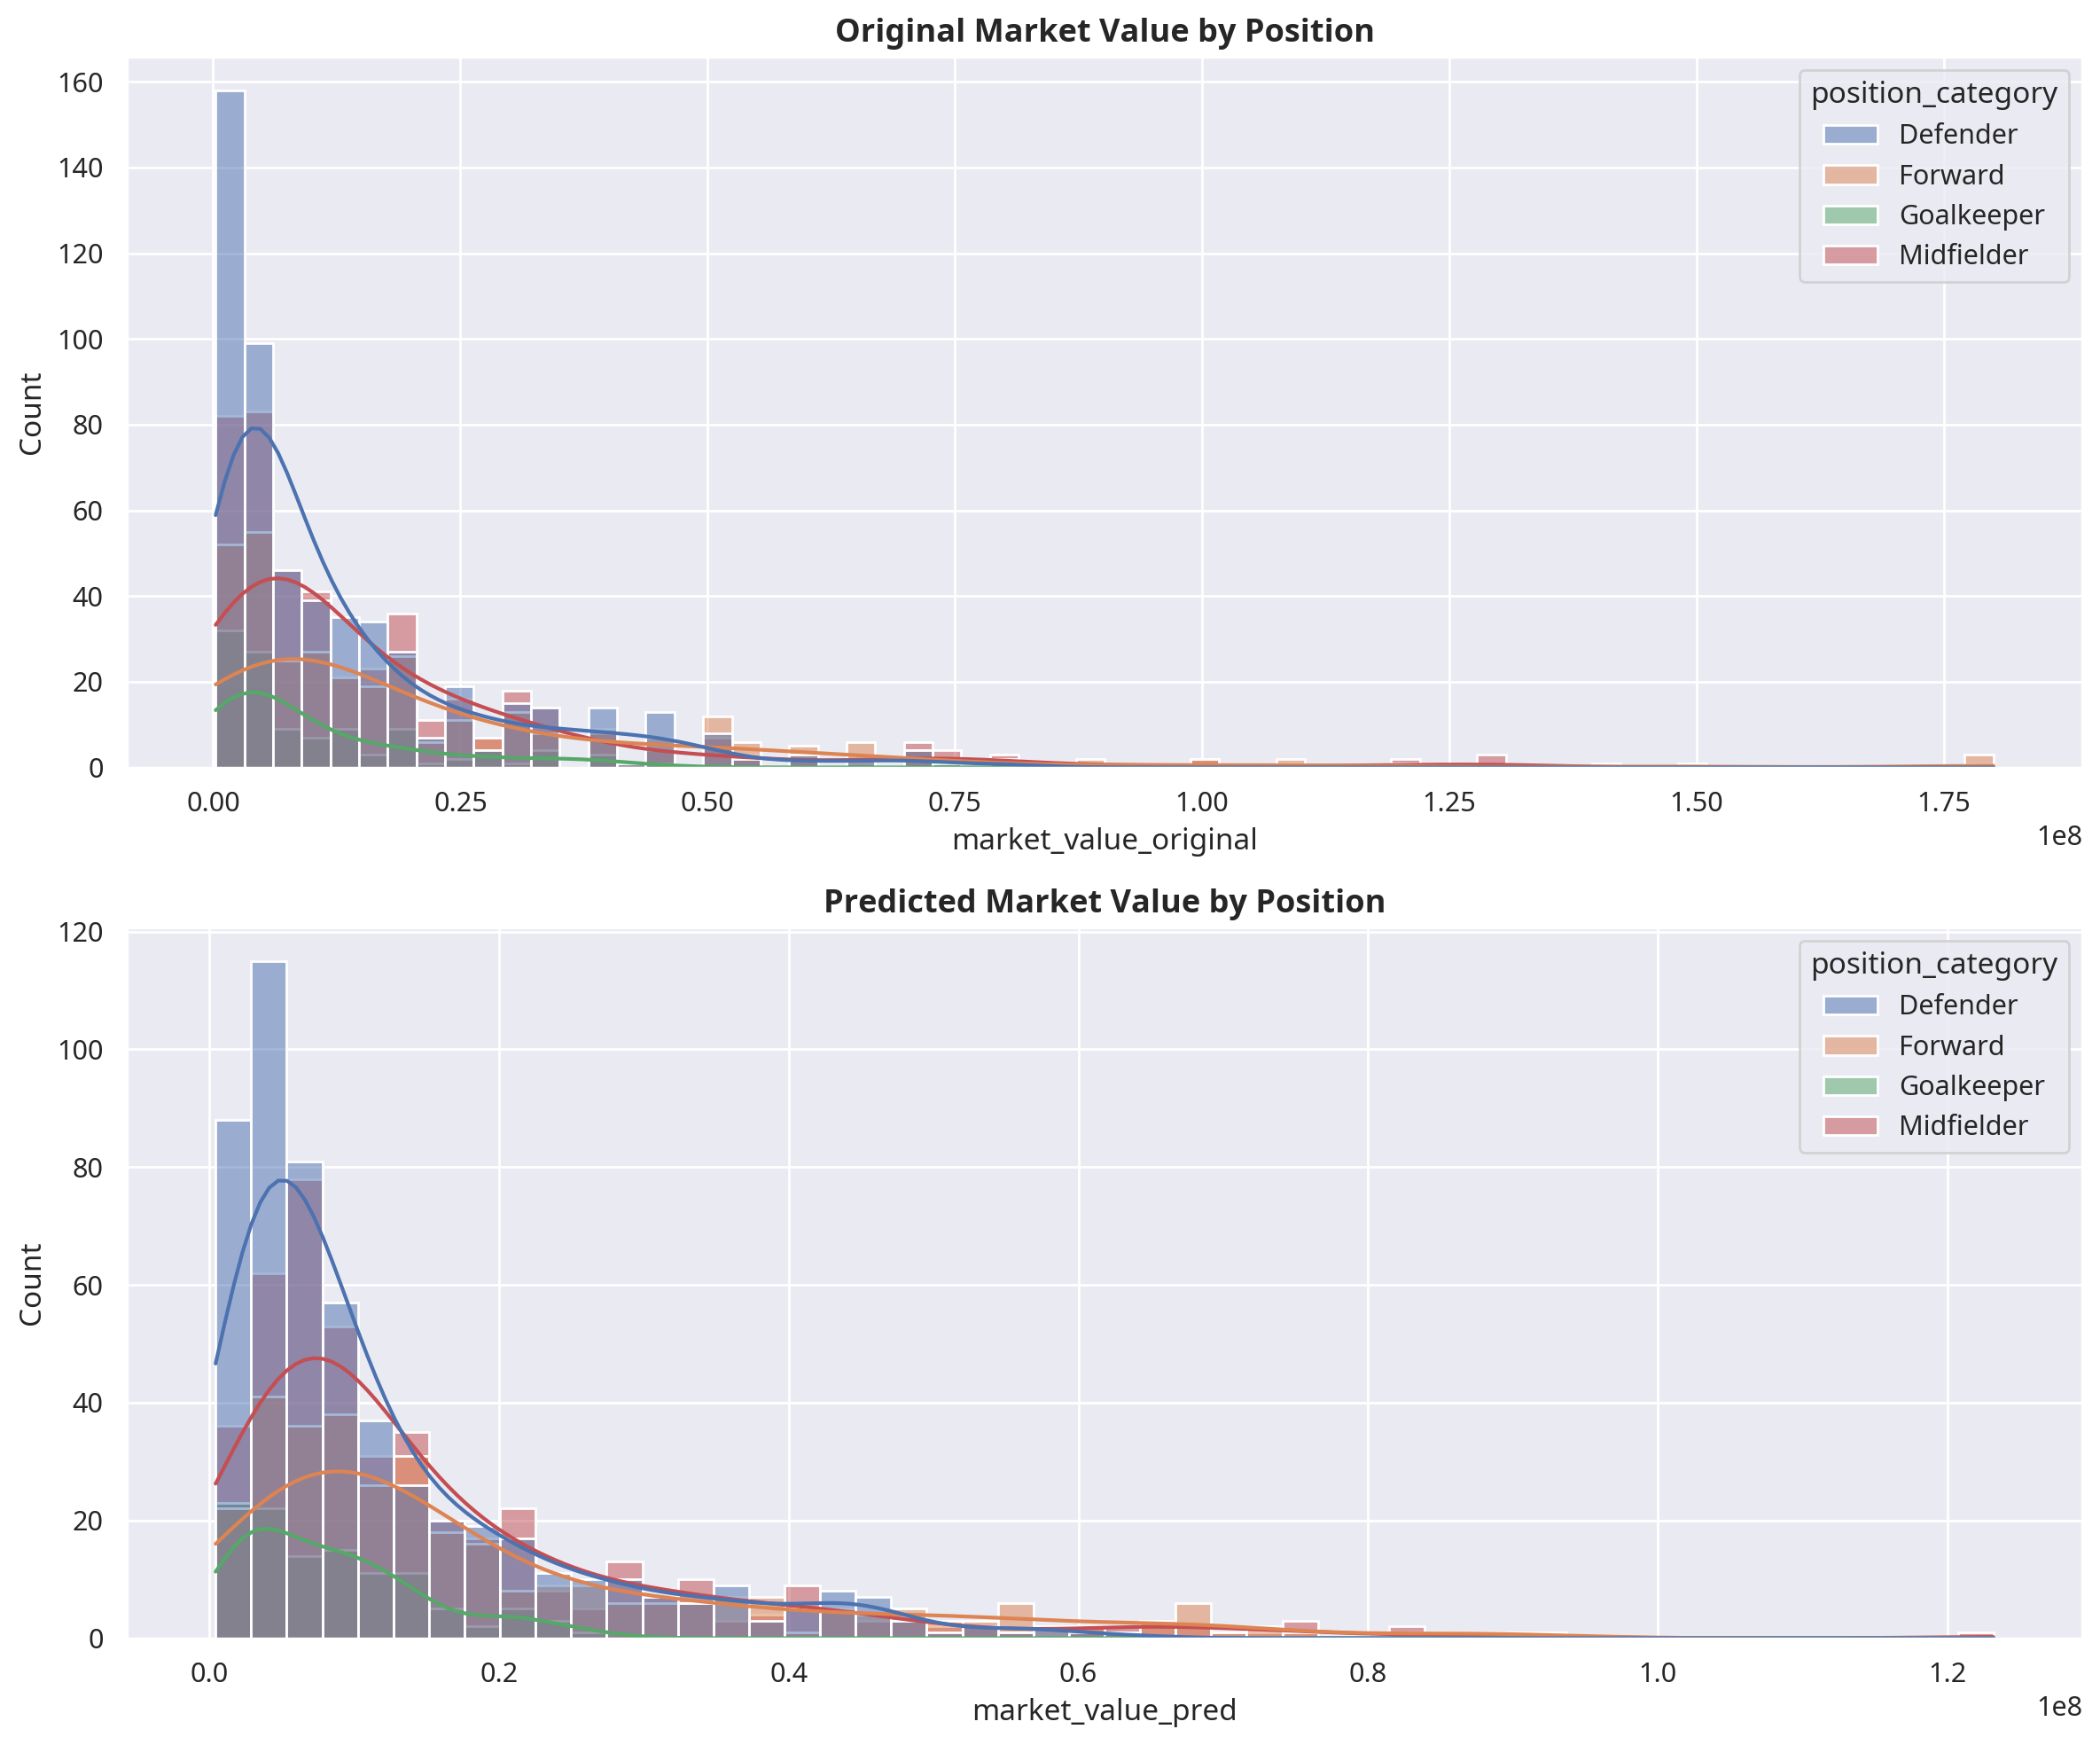

In [265]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

sns.histplot(data=test_copy_lgb, x="market_value_original", kde=True, hue="position_category", ax=axes[0])
axes[0].set_title("Original Market Value by Position", fontsize=13, fontweight="bold")

sns.histplot(data=test_copy_lgb, x="market_value_pred", kde=True, hue="position_category", ax=axes[1])
axes[1].set_title("Predicted Market Value by Position", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.show()

In [266]:
# RMSLE 값 작은 순서대로 Top 10
test_copy_lgb.sort_values(by="market_value_diff_rmsle", ascending=True).head(10)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title,market_value_original,market_value_pred,market_value_diff_rmsle
1319,Willi Orbán,2023,7.367709,bundesliga,Centre-Back,Hungary,right,186.0,31,0.000000,0.034112,0.000000,0.026665,0.037473,0.397979,0.397979,0.539346,0.537888,0.000000,Defender,16.118096,16.117711,RasenBallsport Leipzig,10000000.0,9.996158e+06,0.000384
5373,Iddrisu Baba,2023,7.261927,laliga,Central Midfield,Ghana,right,182.0,28,0.000000,0.094803,0.000000,0.023151,0.028701,0.505618,0.379213,0.115586,0.082590,0.000000,Midfielder,14.603968,14.603500,Almeria,2200000.0,2.198970e+06,0.000468
1197,Loïs Openda,2023,7.907284,bundesliga,Centre-Forward,Belgium,right,177.0,24,0.231959,0.039764,0.729013,0.744586,0.216193,3.976436,1.192931,0.984256,0.144813,0.183333,Forward,17.909855,17.912104,RasenBallsport Leipzig,60000000.0,6.013510e+07,0.002249
2379,Lorenzo Lucca,2023,7.864036,serie-a,Centre-Forward,Italy,right,201.0,23,0.138408,0.062284,0.276817,0.314810,0.050027,2.110727,0.692042,0.373336,0.058904,0.131148,Forward,16.300417,16.298073,Udinese,12000000.0,1.197191e+07,0.002344
3929,James Garner,2023,8.008366,premier-league,Defensive Midfield,England,right,182.0,23,0.059900,0.062895,0.029950,0.066634,0.158364,1.227953,1.287854,0.279498,0.155239,0.024390,Midfielder,16.906553,16.909097,Everton,22000000.0,2.205604e+07,0.002544
2509,Toma Basic,2023,7.062192,serie-a,Central Midfield,Croatia,left,190.0,27,0.000000,0.115780,0.000000,0.034310,0.032266,0.926244,1.234991,0.205691,0.177451,0.000000,Midfielder,14.845130,14.841786,Salernitana,2800000.0,2.790651e+06,0.003345
4055,Pervis Estupiñán,2023,7.127694,premier-league,Left-Back,Ecuador,left,175.0,26,0.216867,0.086747,0.144578,0.074754,0.237568,0.795181,1.879518,0.587815,0.430127,0.181818,Defender,17.216708,17.221040,Brighton,30000000.0,3.013025e+07,0.004332
2394,Manuel Locatelli,2023,8.010360,serie-a,Defensive Midfield,Italy,right,185.0,26,0.119562,0.053803,0.029890,0.035541,0.052253,0.747260,0.777150,0.392185,0.336338,0.040000,Midfielder,17.147715,17.141379,Juventus,28000000.0,2.782316e+07,0.006336
3824,Arijanet Muric,2023,6.803505,premier-league,Goalkeeper,Kosovo,right,198.0,25,0.000000,0.000000,0.000000,0.000000,0.037258,0.000000,0.400000,0.225137,0.187879,0.000000,Goalkeeper,15.761421,15.767798,Burnley,7000000.0,7.044784e+06,0.006377
1244,Min-jae Kim,2023,7.587311,bundesliga,Centre-Back,"Korea, South",right,190.0,27,0.091278,0.041075,0.045639,0.048606,0.029034,0.456389,0.365112,0.743152,0.727728,0.100000,Defender,17.622173,17.628856,Bayern Munich,45000000.0,4.530173e+07,0.006683


In [267]:
# RMSLE 값 큰 순서대로 Top 10
test_copy_lgb.sort_values(by="market_value_diff_rmsle", ascending=False).head(10)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title,market_value_original,market_value_pred,market_value_diff_rmsle
4043,Oliver Arblaster,2023,6.853299,premier-league,Central Midfield,England,right,180.0,20,0.000000,0.057082,0.000000,0.002067,0.097967,0.095137,1.141649,0.274113,0.251627,0.000000,Midfielder,13.017005,16.016042,Sheffield United,450000.0,9.029808e+06,2.999037
5290,André Ferreira,2023,7.200425,laliga,Goalkeeper,Portugal,right,193.0,28,0.000000,0.020164,0.000000,0.000000,0.000000,0.000000,0.000000,0.153897,0.153897,0.000000,Goalkeeper,13.592368,15.773580,Granada,800000.0,7.085634e+06,2.181212
3989,Luke Shaw,2023,6.871091,premier-league,Left-Back,England,left,178.0,28,0.000000,0.168224,0.000000,0.006661,0.089168,0.186916,1.214953,0.204455,0.185026,0.000000,Defender,17.281246,15.265961,Manchester United,32000000.0,4.265033e+06,2.015286
3923,Jack Robinson,2023,7.967973,premier-league,Centre-Back,England,left,180.0,30,0.031185,0.093555,0.031185,0.047142,0.033912,0.436590,0.374220,0.120587,0.085005,0.071429,Defender,13.815512,15.764066,Sheffield United,1000000.0,7.018539e+06,1.948554
5451,Mikel Oyarzabal,2023,7.678326,laliga,Centre-Forward,Spain,left,181.0,27,0.125000,0.037500,0.291667,0.360673,0.091296,1.666667,0.875000,0.438577,0.054798,0.175000,Forward,17.622173,15.692076,Real Sociedad,45000000.0,6.531033e+06,1.930097
1212,Marcel Schuhen,2023,7.934155,bundesliga,Goalkeeper,Germany,right,188.0,31,0.000000,0.019355,0.000000,0.000000,0.002777,0.000000,0.032258,0.114719,0.111942,0.000000,Goalkeeper,13.592368,15.439294,Darmstadt,800000.0,5.072242e+06,1.846925
4064,Reece Burke,2023,7.417580,premier-league,Centre-Back,England,right,189.0,27,0.216346,0.081130,0.000000,0.117070,0.125559,0.703125,0.703125,0.224157,0.209211,0.000000,Defender,14.403298,16.247803,Luton,1800000.0,1.138495e+07,1.844505
3952,Jordan Clark,2023,7.175490,premier-league,Central Midfield,England,right,183.0,30,0.068913,0.082695,0.068913,0.063834,0.127387,1.171516,0.826953,0.301421,0.179655,0.058824,Midfielder,13.815512,15.641234,Luton,1000000.0,6.207282e+06,1.825722
1303,Sven Ulreich,2023,6.898715,bundesliga,Goalkeeper,Germany,right,192.0,35,0.000000,0.027273,0.000000,0.000000,0.006560,0.000000,0.090909,0.434387,0.427827,0.000000,Goalkeeper,13.458837,15.269402,Bayern Munich,700000.0,4.279737e+06,1.810565
3833,Ben Osborn,2023,7.218177,premier-league,Central Midfield,England,left,176.0,29,0.132062,0.059428,0.000000,0.011825,0.071041,0.264123,0.858401,0.202749,0.135048,0.000000,Midfielder,13.815512,15.574198,Sheffield United,1000000.0,5.804813e+06,1.758687


In [268]:
# Arsenal 선수들의 2324 시즌 몸값 비교
test_copy_lgb[test_copy_lgb.team_title=="Arsenal"].sort_values("market_value_diff_rmsle").head(10)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title,market_value_original,market_value_pred,market_value_diff_rmsle
3927,Jakub Kiwior,2023,6.852243,premier-league,Left-Back,Poland,left,189.0,24,0.285714,0.028571,0.095238,0.113921,0.086479,0.571429,0.571429,0.493339,0.380055,0.166667,Defender,17.216708,17.154467,Arsenal,30000000.0,2.818970e+07,0.062241
3967,Kai Havertz,2023,7.878913,premier-league,Attacking Midfield,Germany,left,193.0,24,0.238636,0.112500,0.409091,0.433110,0.198217,2.352273,1.534091,0.845118,0.318618,0.173913,Midfielder,18.064006,18.145429,Arsenal,70000000.0,7.593808e+07,0.081423
3834,Ben White,2023,8.005033,premier-league,Right-Back,England,right,186.0,26,0.120200,0.072120,0.120200,0.060578,0.143003,0.390651,1.141903,0.605488,0.519579,0.307692,Defender,17.822844,17.623437,Arsenal,55000000.0,4.505691e+07,0.199407
3977,Leandro Trossard,2023,7.406711,premier-league,Left Winger,Belgium,right,172.0,29,0.054678,0.032807,0.656136,0.523584,0.177817,3.280680,1.312272,0.928240,0.300886,0.200000,Forward,17.370859,17.605743,Arsenal,35000000.0,4.426668e+07,0.234884
3903,Gabriel Martinelli,2023,7.615791,premier-league,Left Winger,Brazil,right,178.0,22,0.177427,0.013307,0.266141,0.315806,0.236108,2.572696,2.040414,0.745593,0.294456,0.103448,Forward,18.064006,17.822311,Arsenal,70000000.0,5.497071e+07,0.241695
4109,William Saliba,2023,8.137688,premier-league,Centre-Back,France,right,192.0,23,0.026316,0.031579,0.052632,0.062295,0.006550,0.263158,0.157895,0.437678,0.432495,0.200000,Defender,18.197537,17.901008,Arsenal,80000000.0,5.947149e+07,0.296530
3871,David Raya,2023,7.965893,premier-league,Goalkeeper,Spain,right,183.0,28,0.000000,0.018750,0.000000,0.000000,0.000000,0.000000,0.000000,0.234925,0.234925,0.000000,Goalkeeper,17.370859,17.025236,Arsenal,35000000.0,2.477228e+07,0.345623
3902,Gabriel Magalhães,2023,8.021256,premier-league,Centre-Back,Brazil,left,190.0,26,0.000000,0.035480,0.088699,0.119015,0.025864,0.916557,0.088699,0.391234,0.364649,0.096774,Defender,18.064006,17.698434,Arsenal,70000000.0,4.856597e+07,0.365572
4042,Oleksandr Zinchenko,2023,7.453562,premier-league,Left-Back,Ukraine,left,175.0,27,0.104348,0.031304,0.052174,0.029554,0.157901,0.886957,1.513043,0.508965,0.424330,0.058824,Defender,17.453097,17.067685,Arsenal,38000000.0,2.584649e+07,0.385411
3901,Gabriel Jesus,2023,7.302496,premier-league,Centre-Forward,Brazil,right,175.0,27,0.303439,0.109238,0.242751,0.442519,0.257041,3.337829,1.699258,0.913643,0.316210,0.072727,Forward,17.989898,17.575625,Arsenal,65000000.0,4.295336e+07,0.414272


In [269]:
# Tottenham 선수들의 2324 시즌 몸값 비교
test_copy_lgb[test_copy_lgb.team_title=="Tottenham"].sort_values("market_value_diff_rmsle").head(10)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title,market_value_original,market_value_pred,market_value_diff_rmsle
3863,Cristian Romero,2023,7.934872,premier-league,Centre-Back,Argentina,right,185.0,26,0.000000,0.090258,0.161175,0.128460,0.011020,0.773639,0.225645,0.574159,0.530393,0.208333,Defender,17.989898,17.968009,Tottenham,65000000.0,6.359266e+07,0.021889
4115,Yves Bissouma,2023,7.642044,premier-league,Defensive Midfield,Mali,right,182.0,27,0.000000,0.159866,0.000000,0.050395,0.017495,1.036966,0.432069,0.486424,0.457552,0.000000,Midfielder,17.370859,17.348881,Tottenham,35000000.0,3.423918e+07,0.021977
4053,Pedro Porro,2023,8.037220,premier-league,Right-Back,Spain,right,173.0,24,0.203686,0.026188,0.087294,0.082495,0.211985,1.542192,1.513094,0.588821,0.459578,0.056604,Defender,17.622173,17.598731,Tottenham,45000000.0,4.395738e+07,0.023442
3914,Heung-min Son,2023,7.989221,premier-league,Left Winger,"Korea, South",both,184.0,31,0.305292,0.009159,0.457938,0.349751,0.407290,2.594980,2.106513,0.919404,0.318907,0.176471,Forward,17.622173,17.597422,Tottenham,45000000.0,4.389986e+07,0.024751
3930,James Maddison,2023,7.675546,premier-league,Attacking Midfield,England,right,175.0,27,0.376045,0.062674,0.167131,0.263131,0.298428,2.381616,2.757660,0.872151,0.503104,0.070175,Midfielder,18.064006,18.020750,Tottenham,70000000.0,6.703665e+07,0.043256
3830,Ben Davies,2023,6.991177,premier-league,Centre-Back,Wales,left,181.0,31,0.000000,0.049724,0.082873,0.172141,0.025743,0.994475,0.331492,0.631031,0.523669,0.083333,Defender,16.118096,16.202202,Tottenham,10000000.0,1.087744e+07,0.084106
3875,Destiny Udogie,2023,7.782807,premier-league,Left-Back,Italy,left,188.0,21,0.112594,0.078816,0.075063,0.105609,0.095722,0.337781,0.900751,0.557302,0.409339,0.222222,Defender,17.622173,17.536880,Tottenham,45000000.0,4.132094e+07,0.085293
4065,Richarlison,2023,7.308543,premier-league,Centre-Forward,Brazil,right,184.0,27,0.241287,0.054290,0.663539,0.580238,0.118691,3.679625,0.904826,0.768204,0.138056,0.180328,Forward,17.453097,17.308055,Tottenham,38000000.0,3.286949e+07,0.145041
4068,Rodrigo Bentancur,2023,6.915723,premier-league,Central Midfield,Uruguay,right,187.0,26,0.089374,0.187686,0.089374,0.145018,0.045019,1.608739,0.714995,0.766525,0.660432,0.055556,Midfielder,17.370859,17.222671,Tottenham,35000000.0,3.017943e+07,0.148187
3874,Dejan Kulusevski,2023,7.925519,premier-league,Right Winger,Sweden,left,186.0,24,0.097614,0.068330,0.260304,0.189874,0.280334,1.854664,2.114967,0.771707,0.406961,0.140351,Forward,17.822844,17.626566,Tottenham,55000000.0,4.519811e+07,0.196278


In [270]:
# Manchester City 선수들의 2324 시즌 몸값 비교
test_copy_lgb[test_copy_lgb.team_title=="Manchester City"].sort_values("market_value_diff_rmsle").head(10)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title,market_value_original,market_value_pred,market_value_diff_rmsle
3994,Manuel Akanji,2023,7.830028,premier-league,Centre-Back,Switzerland,right,188.0,28,0.000000,0.042959,0.071599,0.078773,0.018850,0.536993,0.465394,0.597886,0.567032,0.133333,Defender,17.622173,17.642692,Manchester City,45000000.0,4.593289e+07,0.020519
3836,Bernardo Silva,2023,7.856707,premier-league,Attacking Midfield,Portugal,left,173.0,29,0.313710,0.083656,0.209140,0.142801,0.297276,1.185128,2.265686,0.849532,0.542972,0.176471,Midfielder,18.064006,18.041962,Manchester City,70000000.0,6.847379e+07,0.022044
4028,Nathan Aké,2023,7.623153,premier-league,Centre-Back,Netherlands,left,180.0,29,0.088063,0.000000,0.088063,0.095993,0.076475,0.880626,0.440313,0.581018,0.532001,0.100000,Defender,17.504390,17.480705,Manchester City,40000000.0,3.906374e+07,0.023685
3965,Jérémy Doku,2023,7.374629,premier-league,Left Winger,Belgium,right,173.0,22,0.508156,0.050816,0.169385,0.212852,0.309187,3.161857,2.540778,0.825604,0.434883,0.053571,Forward,17.989898,17.888854,Manchester City,65000000.0,5.875310e+07,0.101043
3963,Julián Álvarez,2023,7.886081,premier-league,Centre-Forward,Argentina,right,170.0,24,0.304626,0.020308,0.304626,0.434980,0.197097,3.317036,2.233923,0.919368,0.443038,0.091837,Forward,18.315320,18.136201,Manchester City,90000000.0,7.524058e+07,0.179119
4005,Mateo Kovacic,2023,7.345365,premier-league,Central Midfield,Croatia,right,177.0,30,0.000000,0.069767,0.058140,0.083104,0.098000,1.279070,1.220930,0.785695,0.710831,0.045455,Midfielder,17.216708,16.909162,Manchester City,30000000.0,2.205747e+07,0.307546
4074,Rúben Dias,2023,7.846981,premier-league,Centre-Back,Portugal,right,187.0,27,0.000000,0.000000,0.000000,0.064345,0.021136,0.703950,0.246382,0.591706,0.579300,0.000000,Defender,18.197537,17.863265,Manchester City,80000000.0,5.726874e+07,0.334272
4067,Rodri,2023,7.985825,premier-league,Defensive Midfield,Spain,right,191.0,27,0.275698,0.094963,0.245065,0.131547,0.163153,1.899251,1.531654,0.968710,0.805397,0.129032,Midfielder,18.683045,18.333818,Manchester City,130000000.0,9.168029e+07,0.349227
3976,Kyle Walker,2023,7.926242,premier-league,Right-Back,England,right,178.0,34,0.130058,0.019509,0.000000,0.011868,0.108672,0.520231,0.812861,0.715263,0.652413,0.000000,Defender,16.380460,15.983673,Manchester City,13000000.0,8.742205e+06,0.396787
3887,Ederson,2023,7.933438,premier-league,Goalkeeper,Brazil,left,188.0,30,0.000000,0.048422,0.000000,0.000000,0.000000,0.000000,0.000000,0.259348,0.259348,0.000000,Goalkeeper,17.370859,16.927688,Manchester City,35000000.0,2.246992e+07,0.443170


In [271]:
# 몸값이 비싼 순서대로 market_value_diff_rmsle를 오름차순 정렬
test_copy_lgb.sort_values(by=["market_value_original", "market_value_diff_rmsle"], ascending=[False, True]).head(10)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title,market_value_original,market_value_pred,market_value_diff_rmsle
5413,Jude Bellingham,2023,7.751475,laliga,Attacking Midfield,England,right,186.0,20,0.232358,0.085198,0.697074,0.473671,0.228272,2.439759,1.858864,1.061969,0.599283,0.285714,Midfielder,19.008467,18.629111,Real Madrid,1.800000e+08,1.231743e+08,0.379357
5521,Vinicius Junior,2023,7.536897,laliga,Left Winger,Brazil,right,176.0,23,0.288000,0.100800,0.672000,0.732279,0.212812,3.744000,1.488000,0.984842,0.232084,0.179487,Forward,19.008467,18.266068,Real Madrid,1.800000e+08,8.567472e+07,0.742399
6829,Kylian Mbappé,2023,7.677864,ligue-1,Centre-Forward,France,right,178.0,25,0.291802,0.050023,0.875405,0.634630,0.254753,5.002316,1.667439,1.138126,0.401098,0.175000,Forward,19.008467,18.031628,Paris Saint Germain,1.800000e+08,6.776985e+07,0.976839
3894,Erling Haaland,2023,7.847372,premier-league,Centre-Forward,Norway,left,195.0,23,0.175919,0.010555,0.703675,0.899460,0.167185,4.292416,1.020328,1.062452,0.110077,0.163934,Forward,19.008467,17.801684,Manchester City,1.800000e+08,5.384845e+07,1.206783
4056,Phil Foden,2023,7.962764,premier-league,Right Winger,England,left,171.0,24,0.250784,0.018809,0.595611,0.354482,0.266967,3.291536,2.288401,0.953510,0.532884,0.180952,Forward,18.826146,18.302003,Manchester City,1.500000e+08,8.880943e+07,0.524142
3844,Bukayo Saka,2023,7.985144,premier-league,Right Winger,England,left,178.0,22,0.275886,0.036785,0.306540,0.375206,0.347186,3.279973,2.728202,0.930580,0.405509,0.093458,Forward,18.757153,18.220854,Arsenal,1.400000e+08,8.188728e+07,0.536299
4067,Rodri,2023,7.985825,premier-league,Defensive Midfield,Spain,right,191.0,27,0.275698,0.094963,0.245065,0.131547,0.163153,1.899251,1.531654,0.968710,0.805397,0.129032,Midfielder,18.683045,18.333818,Manchester City,1.300000e+08,9.168029e+07,0.349227
1129,Florian Wirtz,2023,7.776954,bundesliga,Attacking Midfield,Germany,right,177.0,21,0.453020,0.033977,0.377517,0.324645,0.335485,2.680369,2.718121,1.076738,0.574811,0.140845,Midfielder,18.683045,18.243061,Bayer Leverkusen,1.300000e+08,8.372607e+07,0.439984
1145,Jamal Musiala,2023,7.477604,bundesliga,Attacking Midfield,Germany,right,184.0,21,0.305603,0.030560,0.509338,0.426554,0.318741,2.954160,2.088285,1.230858,0.574013,0.172414,Midfielder,18.683045,18.242572,Bayern Munich,1.300000e+08,8.368513e+07,0.440473
5424,Lamine Yamal,2023,7.694848,laliga,Right Winger,Spain,left,180.0,16,0.286885,0.036885,0.204918,0.237413,0.274653,2.377049,1.598361,0.921121,0.493208,0.086207,Forward,18.603002,18.060786,Barcelona,1.200000e+08,6.977497e+07,0.542216


In [273]:
# 몸값이 싼 순서대로 market_value_diff_rmsle를 오름차순 정렬
test_copy_lgb.sort_values(by=["market_value_original", "market_value_diff_rmsle"], ascending=[True, True]).head(10)

,player_name,start_season,log_minutes_played,competition_code,position,country,foot,height_in_cm,age,assists_90,aggression_90,npG_90,npxG_90,xA_90,shots_90,key_passes_90,xGChain_90,xGBuildup_90,npG_conv,position_category,log_market_value_per_season,log_market_value_pred,team_title,market_value_original,market_value_pred,market_value_diff_rmsle
6795,Ismaël Traoré,2023,7.706163,ligue-1,Centre-Back,Cote d'Ivoire,right,184.0,37,0.000000,0.024313,0.081045,0.041670,0.003638,0.405223,0.081045,0.080531,0.079004,0.200000,Defender,12.429220,12.962129,Metz,250000.0,4.259709e+05,0.532909
1259,Norman Theuerkauf,2023,7.138073,bundesliga,Defensive Midfield,Germany,left,183.0,37,0.071542,0.064388,0.000000,0.040288,0.054490,0.500795,0.786963,0.194339,0.134925,0.000000,Midfielder,12.611541,13.078828,FC Heidenheim,300000.0,4.786984e+05,0.467287
6767,Florent Ogier,2023,6.848005,ligue-1,Centre-Back,France,right,183.0,35,0.095643,0.028693,0.095643,0.021874,0.054037,0.573858,0.095643,0.175086,0.175086,0.166667,Defender,12.611541,13.085991,Clermont Foot,300000.0,4.821397e+05,0.474450
2307,Federico Fazio,2023,7.213032,serie-a,Centre-Back,Argentina,right,195.0,37,0.000000,0.059735,0.066372,0.040368,0.008164,0.530973,0.199115,0.223815,0.213903,0.125000,Defender,12.899222,13.486706,Salernitana,400000.0,7.197826e+05,0.587483
1187,Klaus Gjasula,2023,7.220374,bundesliga,Defensive Midfield,Albania,both,190.0,34,0.000000,0.184480,0.000000,0.048073,0.014662,0.592972,0.395315,0.271725,0.247749,0.000000,Midfielder,12.899222,13.955028,Darmstadt,400000.0,1.149718e+06,1.055806
4043,Oliver Arblaster,2023,6.853299,premier-league,Central Midfield,England,right,180.0,20,0.000000,0.057082,0.000000,0.002067,0.097967,0.095137,1.141649,0.274113,0.251627,0.000000,Midfielder,13.017005,16.016042,Sheffield United,450000.0,9.029808e+06,2.999037
1091,Cristian Gamboa,2023,7.080026,bundesliga,Right-Back,Costa Rica,right,175.0,34,0.075821,0.159225,0.000000,0.005759,0.051961,0.454928,0.758214,0.236181,0.185504,0.000000,Defender,13.122365,13.227617,Bochum,500000.0,5.554953e+05,0.105252
1066,Anthony Losilla,2023,7.858641,bundesliga,Defensive Midfield,France,right,185.0,38,0.069579,0.104368,0.034789,0.075051,0.055737,0.939312,0.660997,0.220860,0.129387,0.037037,Midfielder,13.122365,13.274614,Bochum,500000.0,5.822249e+05,0.152248
6803,Johan Gastien,2023,7.729735,ligue-1,Defensive Midfield,France,right,179.0,36,0.000000,0.083113,0.000000,0.008659,0.081985,0.435356,1.266491,0.289083,0.246925,0.000000,Midfielder,13.122365,13.470129,Clermont Foot,500000.0,7.079489e+05,0.347763
1311,Tobias Kempe,2023,7.209340,bundesliga,Central Midfield,Germany,right,184.0,34,0.133235,0.019985,0.000000,0.078927,0.148400,1.398964,1.865285,0.282374,0.162427,0.000000,Midfielder,13.122365,13.655083,Darmstadt,500000.0,8.517786e+05,0.532718
